In [16]:
from os import listdir
from pandas import read_csv
from json import load
from torch import from_numpy,zeros,cat
import torch
from torch.utils.data import DataLoader,TensorDataset
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix
from seaborn import heatmap
from tqdm import tqdm

DATA_DIR = f'../data/nursing/'
LABEL_DIR = f'../data/nursing_andrew'
DEVICE = f'mps'
def get_labeled_nursing_ids():
    return sorted([int(file.split('_')[0]) for file in listdir(f'../data/nursing_andrew')])
def load_feature_label_pair(index=0,data_dir=DATA_DIR,label_dir=LABEL_DIR):
    X = load_features(index,data_dir)
    y = load_labels(index,len(X),label_dir)
    return X,y
def load_features(index=0,data_dir=DATA_DIR):
    return from_numpy(read_csv(f'{data_dir}/{index}/raw_data.csv',header=None)[[2,3,4]].to_numpy())
def load_labels(index,length,label_dir=LABEL_DIR):
    with open(f'{label_dir}/{index}_data.json','r') as f:
        data = load(f)
    y = zeros(length)
    for puff in data['puffs']:
        y[puff['start']:puff['end']] = 1
    y = y.unsqueeze(1).float()
    return y
def window_epoched_signal(X,windowsize,zero_padding=True):
    """
    only works for odd windows, puts label at center
    """
    if(zero_padding):
        X = torch.cat([torch.zeros(windowsize//2,3),X,torch.zeros(windowsize//2,3)])
    cat = [X[:-(windowsize-1)]]
    for i in range(1,(windowsize-1)):
        cat.append(X[i:i-(windowsize-1)])
    cat.append(X[(windowsize-1):])
    cat = [xi.unsqueeze(2) for xi in cat]
    X = torch.cat(cat,axis=2).float()
    return X
def cm_grid(y_true,y_pred,save_path='cm.jpg'):
    fig,axes = plt.subplots(2,2,figsize=(5,5))
    heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,fmt='.2f',cbar=False,ax=axes[0][0])
    heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,fmt='.2f',cbar=False,ax=axes[0][1])
    heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='all'),annot=True,fmt='.2f',cbar=False,ax=axes[1][0])
    heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,fmt='.0f',cbar=False,ax=axes[1][1])
    axes[0][0].set_title('Recall')
    axes[0][1].set_title('Precision')
    axes[1][0].set_title('Proportion')
    axes[1][1].set_title('Count')
    axes[0][0].set_xticks([])
    axes[0][1].set_xticks([])
    axes[0][1].set_yticks([])
    axes[1][1].set_yticks([])
    # axes[0][0].set_yticklabels(['P','S','W'])
    # axes[1][0].set_yticklabels(['P','S','W'])
    # axes[1][0].set_xticklabels(['P','S','W'])
    # axes[1][1].set_xticklabels(['P','S','W'])
    plt.savefig(save_path,dpi=200,bbox_inches='tight')
    
def metrics(y_true,y_pred):
    return {
        'precision':precision_score(y_true=y_true,y_pred=y_pred,average='macro'),
        'recall':recall_score(y_true=y_true,y_pred=y_pred,average='macro'),
        'f1':f1_score(y_true=y_true,y_pred=y_pred,average='macro')
    }
def evaluate(dataloader,model,criterion):
    with torch.no_grad():
        y_true = torch.Tensor()
        y_pred = torch.Tensor()
        y_logits = torch.Tensor()
        loss_total = 0
        for (Xi,yi) in tqdm(dataloader):
            y_true = torch.cat([y_true,yi.round()])
            logits = model(Xi)
            loss = criterion(logits,yi)
            loss_total += loss.item()
            
            y_logits = torch.cat([y_logits,torch.sigmoid(logits).detach().cpu()])
            y_pred = torch.cat([y_pred,torch.sigmoid(logits).round().detach().cpu()])

    return loss_total/len(dataloader),metrics(y_true,y_pred),y_true,y_pred,y_logits


In [17]:
windowsize = 101
X,y = load_feature_label_pair(index=0)
X = window_epoched_signal(X,101)
trainloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True)

In [18]:
class MODEL(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.lstm = nn.LSTM(input_size=3,hidden_size=64,batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x):
        x = x.transpose(1,2)
        o,(h,c) = self.lstm(x)
        x = self.classifier(h.squeeze(0))
        return x
model = MODEL()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

100%|██████████| 4469/4469 [01:14<00:00, 59.71it/s]


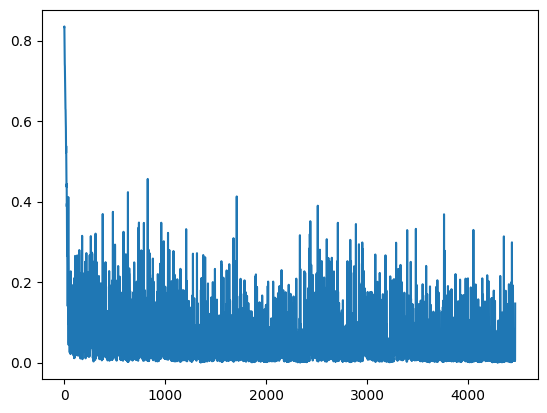

In [19]:
lossi = []
for i in range(1):
    for xi,yi in tqdm(trainloader):
        logits = model(xi)
        loss = criterion(logits,yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
plt.plot(lossi)

1


100%|██████████| 4875/4875 [00:29<00:00, 165.20it/s]


0.17971178779297944
{'precision': 0.8441123163738504, 'recall': 0.6981481860018188, 'f1': 0.7491080979828824}
2


100%|██████████| 3688/3688 [00:22<00:00, 162.62it/s]


0.1604944568627862
{'precision': 0.6817811894704974, 'recall': 0.7355220081047944, 'f1': 0.7046417020578041}
3


100%|██████████| 3313/3313 [00:20<00:00, 163.94it/s]


0.1640766300598681
{'precision': 0.7917169395683228, 'recall': 0.7078894637958725, 'f1': 0.7417331243027989}
4


100%|██████████| 12829/12829 [01:21<00:00, 157.71it/s]


0.15069139620779545
{'precision': 0.5969570100172121, 'recall': 0.8830751781732795, 'f1': 0.6434407127247598}
5


100%|██████████| 3438/3438 [00:21<00:00, 160.85it/s]


0.2647449493792827
{'precision': 0.5926008378800643, 'recall': 0.5508140281296602, 'f1': 0.5639651113335673}
6


100%|██████████| 4282/4282 [00:26<00:00, 161.69it/s]


0.08929260953862815
{'precision': 0.5267067250073849, 'recall': 0.5408578881124012, 'f1': 0.531908023054308}
7


100%|██████████| 3250/3250 [00:20<00:00, 162.04it/s]


0.2978428761874378
{'precision': 0.4831507589526944, 'recall': 0.48898776971263797, 'f1': 0.4860517407526377}
8


100%|██████████| 3344/3344 [00:20<00:00, 161.61it/s]


0.28614274042976134
{'precision': 0.5806813861654478, 'recall': 0.6818709993971689, 'f1': 0.6063069993954819}
9


100%|██████████| 4282/4282 [00:26<00:00, 162.70it/s]


0.27734123086173057
{'precision': 0.7059297035230254, 'recall': 0.7649484245988951, 'f1': 0.7309470643371903}
10


100%|██████████| 3547/3547 [00:21<00:00, 168.52it/s]


0.30687474410016574
{'precision': 0.6662729762923549, 'recall': 0.6174809990541724, 'f1': 0.6363517997708017}
11


100%|██████████| 3969/3969 [00:23<00:00, 166.90it/s]
/var/folders/_z/379dczw91pg5245qx8z89jw80000gn/T/ipykernel_42961/1507289586.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(30,5),gridspec_kw={'height_ratios': [1,5]})


0.40315112532253666
{'precision': 0.69439874780979, 'recall': 0.560932528262334, 'f1': 0.5841455163468627}
12


100%|██████████| 4579/4579 [00:27<00:00, 168.85it/s]


0.22320150716338716
{'precision': 0.718933210945142, 'recall': 0.6826085898844348, 'f1': 0.698786129033654}
13


100%|██████████| 4750/4750 [00:27<00:00, 169.75it/s]


0.2634499608848674
{'precision': 0.48252591142874424, 'recall': 0.49752409702732164, 'f1': 0.4888973358664375}
14


100%|██████████| 4563/4563 [00:27<00:00, 167.24it/s]


0.21437295359021258
{'precision': 0.8765882033330641, 'recall': 0.7848992979727827, 'f1': 0.8232120518566314}
15


100%|██████████| 4110/4110 [00:24<00:00, 166.82it/s]


0.37202249463137194
{'precision': 0.5832738818131212, 'recall': 0.5661829636471534, 'f1': 0.5733405183107109}
16


100%|██████████| 4454/4454 [00:25<00:00, 174.00it/s]


0.19304929362809178
{'precision': 0.7293476690325118, 'recall': 0.5912433370094683, 'f1': 0.625855629143276}
17


100%|██████████| 3313/3313 [00:19<00:00, 173.08it/s]


0.6228113843873682
{'precision': 0.5065875619704442, 'recall': 0.5147067683337757, 'f1': 0.4988854715281855}
18


100%|██████████| 4813/4813 [00:27<00:00, 174.47it/s]


0.2502136758935057
{'precision': 0.48894556215610074, 'recall': 0.4937728918092398, 'f1': 0.4905202691575923}
20


100%|██████████| 5047/5047 [00:28<00:00, 174.35it/s]


0.15026214356384715
{'precision': 0.6945466962168849, 'recall': 0.7986374288426907, 'f1': 0.7339089879151428}
21


100%|██████████| 6047/6047 [00:35<00:00, 172.70it/s]


0.40123743427282227
{'precision': 0.6014650592803685, 'recall': 0.7247967749872306, 'f1': 0.6259974543314676}
22


100%|██████████| 6110/6110 [00:35<00:00, 173.90it/s]


0.2857633782836339
{'precision': 0.6737290052496145, 'recall': 0.6751971401153856, 'f1': 0.6744591370258871}
23


100%|██████████| 6094/6094 [00:35<00:00, 173.62it/s]


0.3615385081356039
{'precision': 0.5145241591162786, 'recall': 0.6708313188223758, 'f1': 0.49597934822171585}
25


100%|██████████| 4891/4891 [00:28<00:00, 174.68it/s]


0.33063767288588636
{'precision': 0.48361792845053675, 'recall': 0.48946207077978726, 'f1': 0.48642141752490803}
27


100%|██████████| 4438/4438 [00:25<00:00, 174.71it/s]


0.2572784364636493
{'precision': 0.8266370041295306, 'recall': 0.7693072330475519, 'f1': 0.7945076578064418}
28


100%|██████████| 4219/4219 [00:24<00:00, 174.75it/s]


0.43640307354241187
{'precision': 0.4726649019540065, 'recall': 0.464983573462709, 'f1': 0.4687501903559814}
29


100%|██████████| 8219/8219 [00:48<00:00, 168.26it/s]


0.32097180843959244
{'precision': 0.48648826774149273, 'recall': 0.47916679039020793, 'f1': 0.48265952151654035}


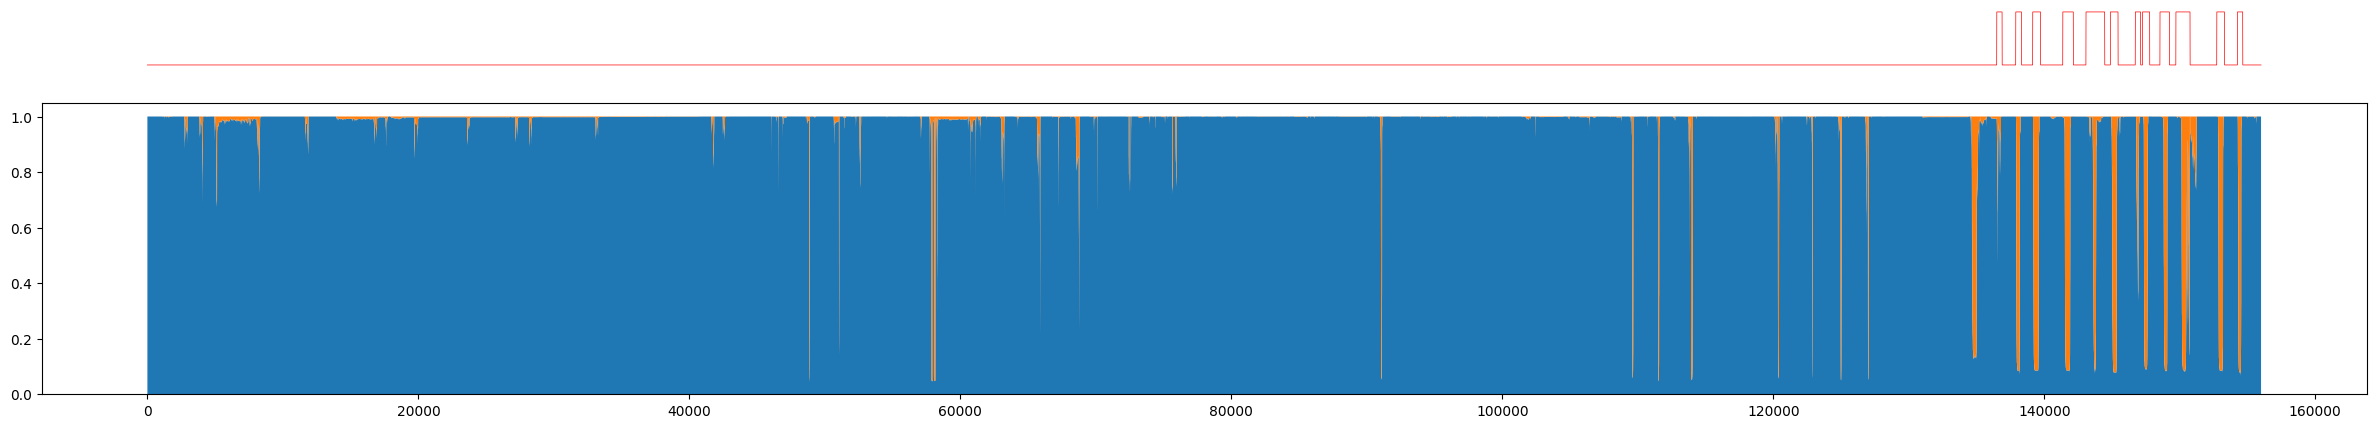

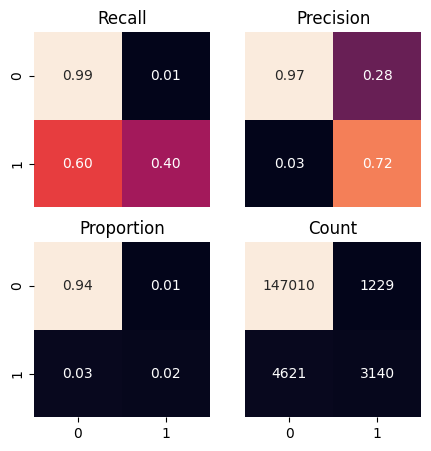

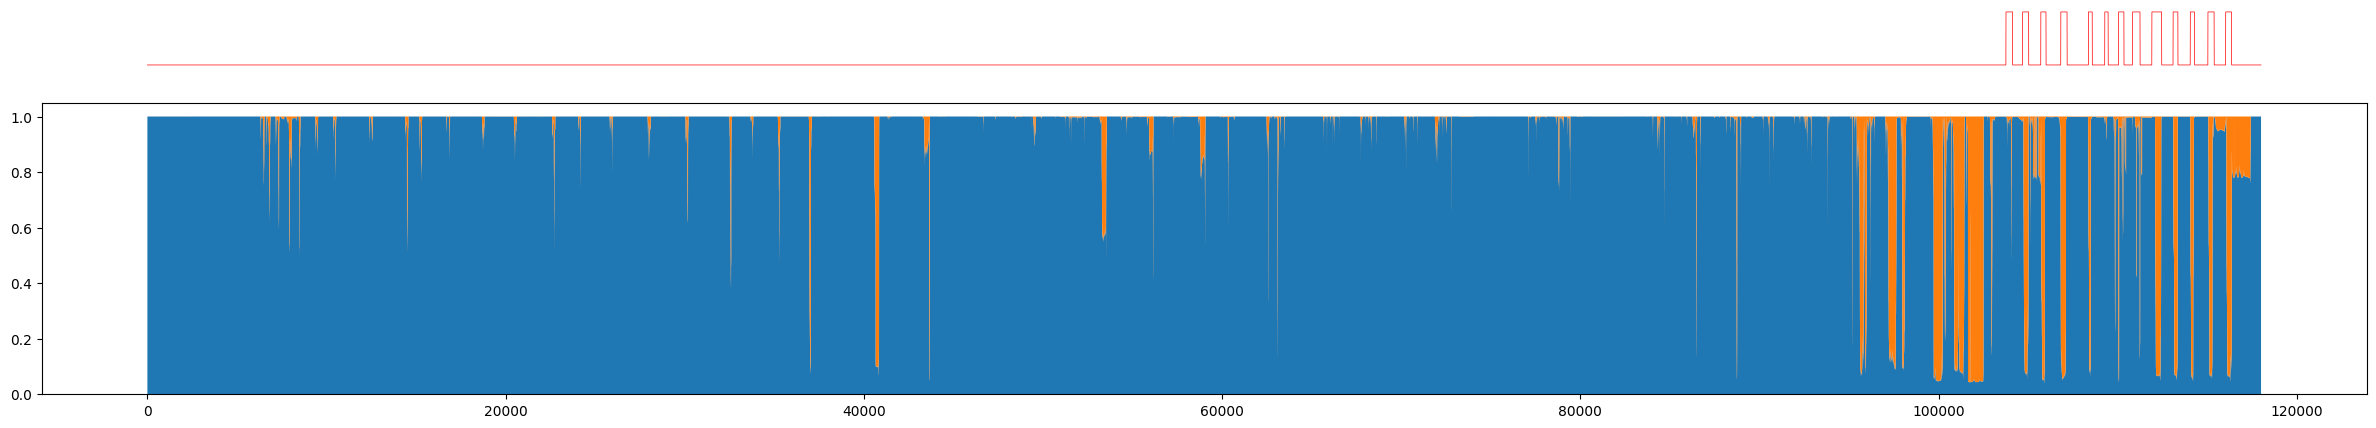

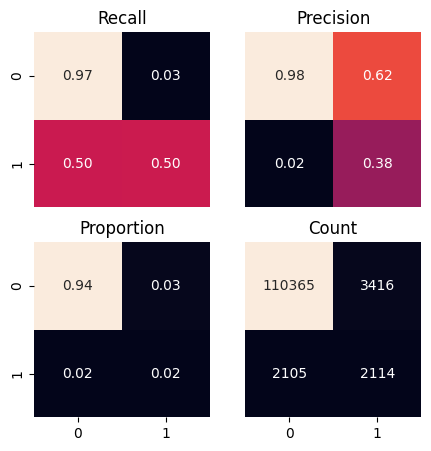

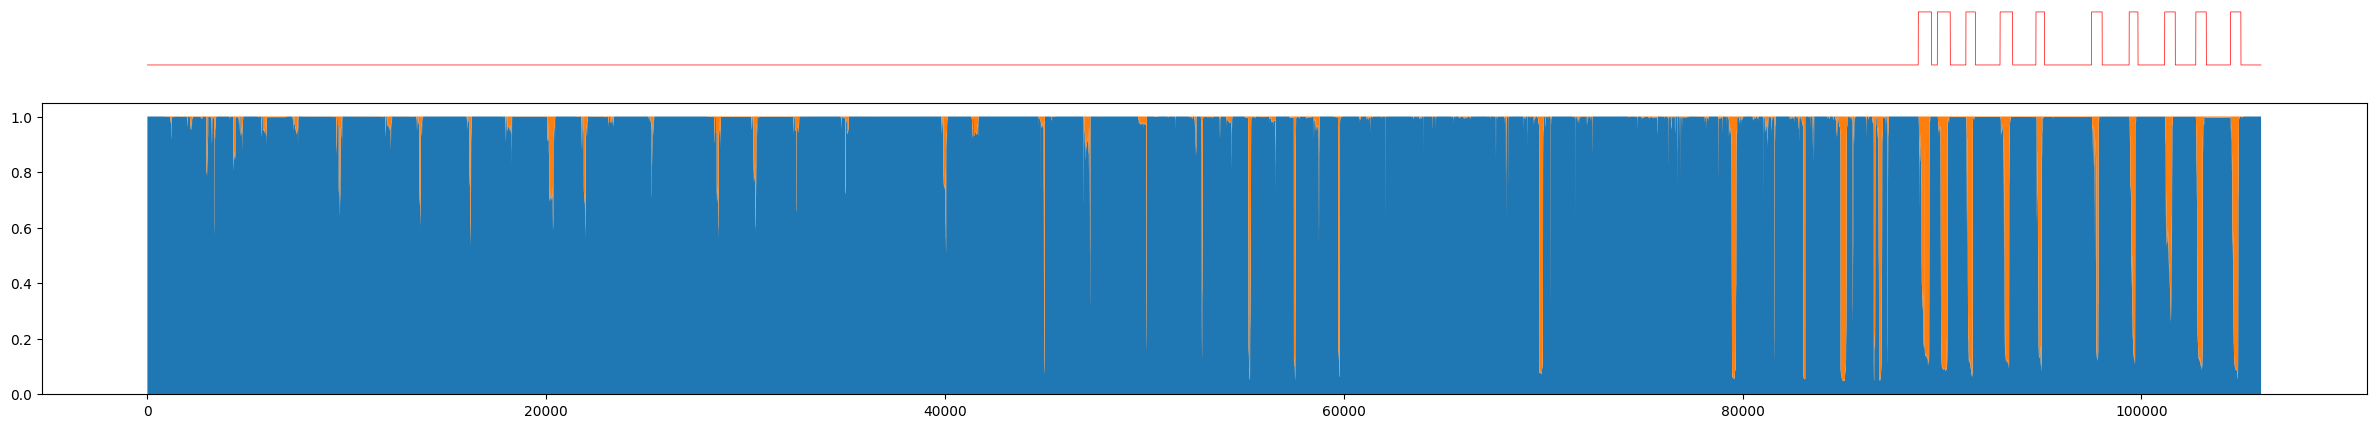

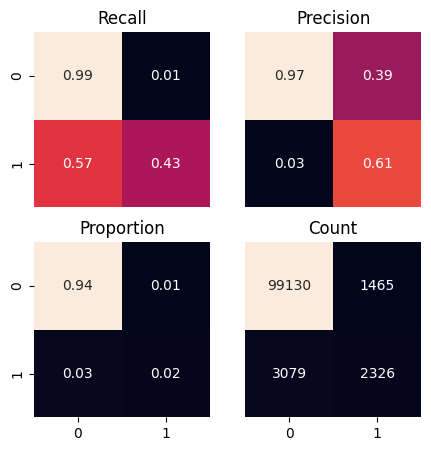

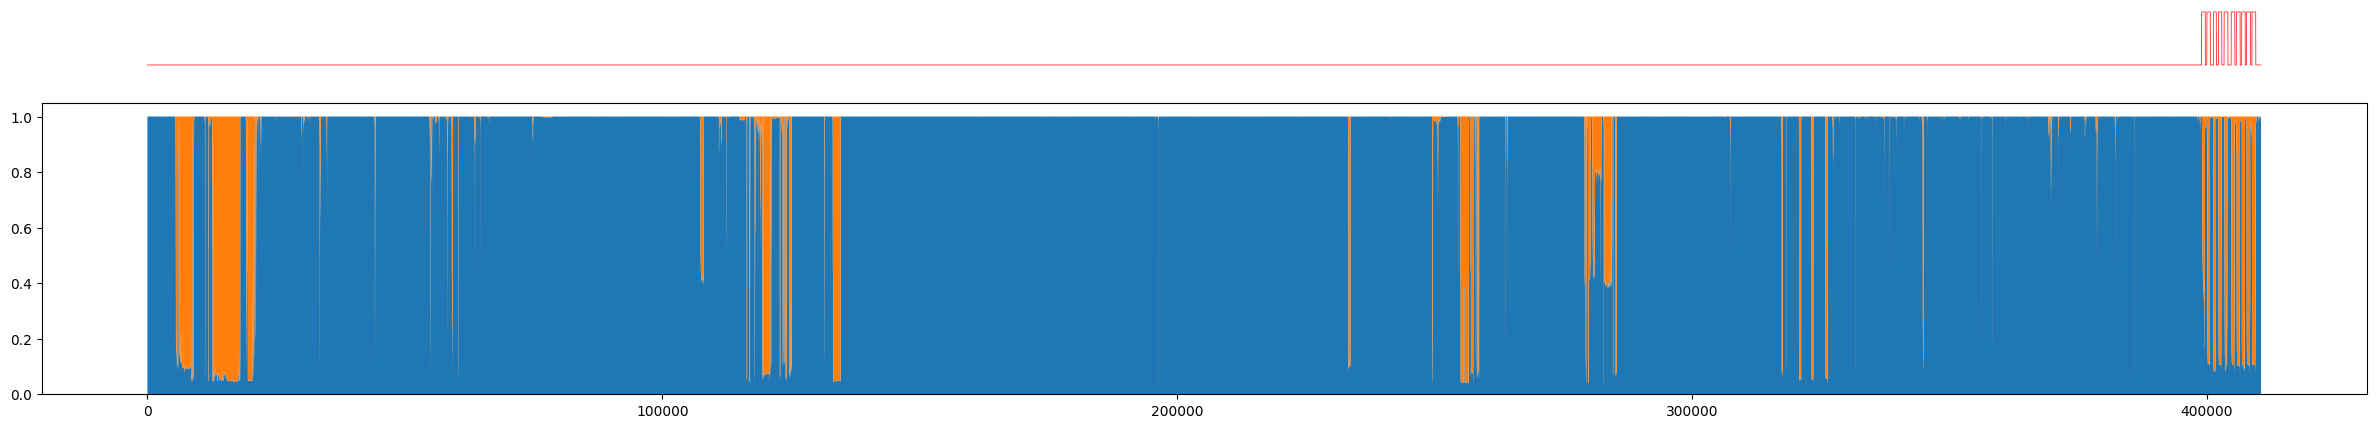

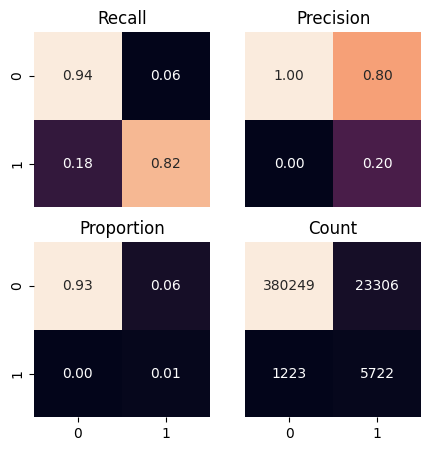

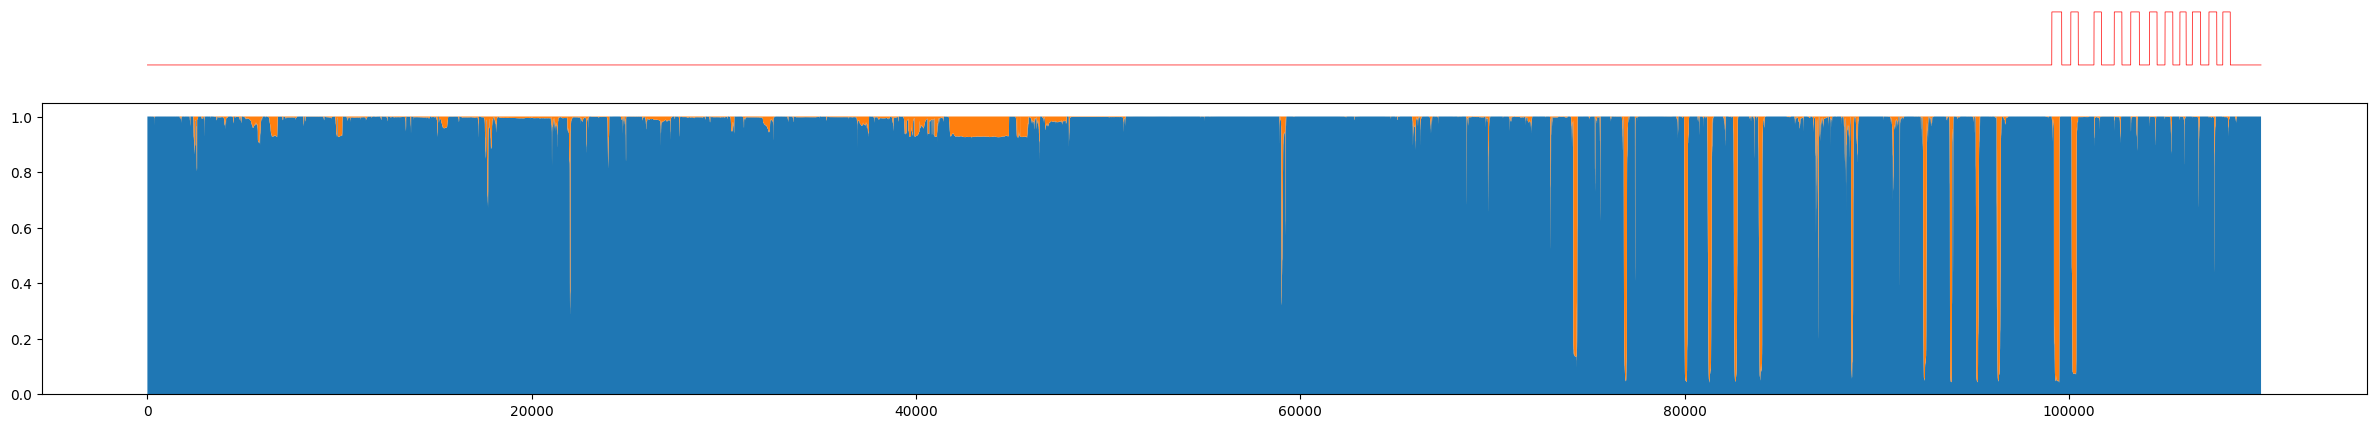

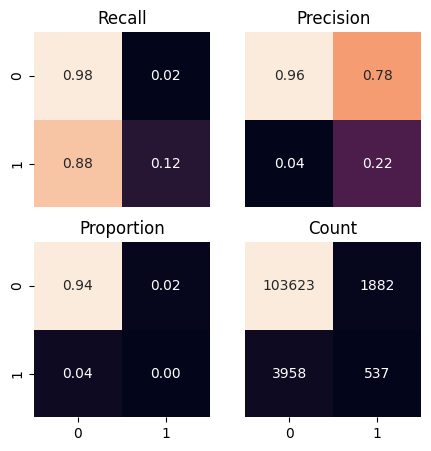

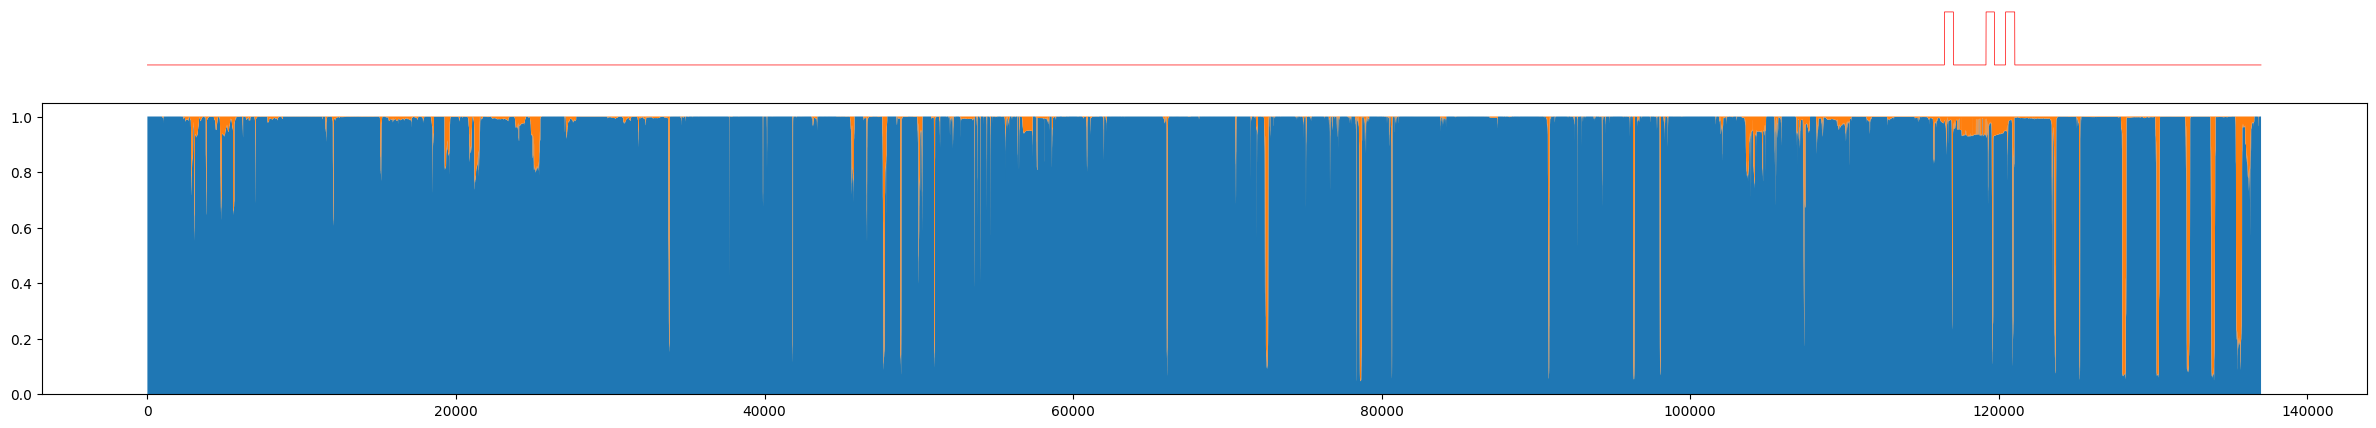

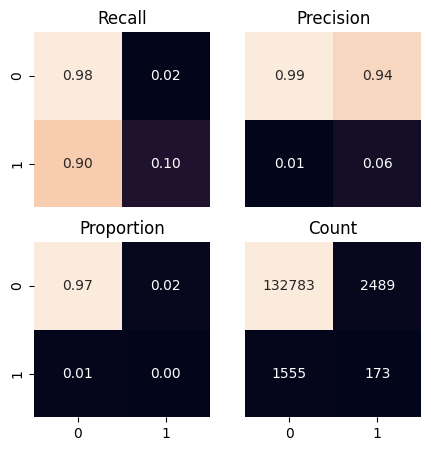

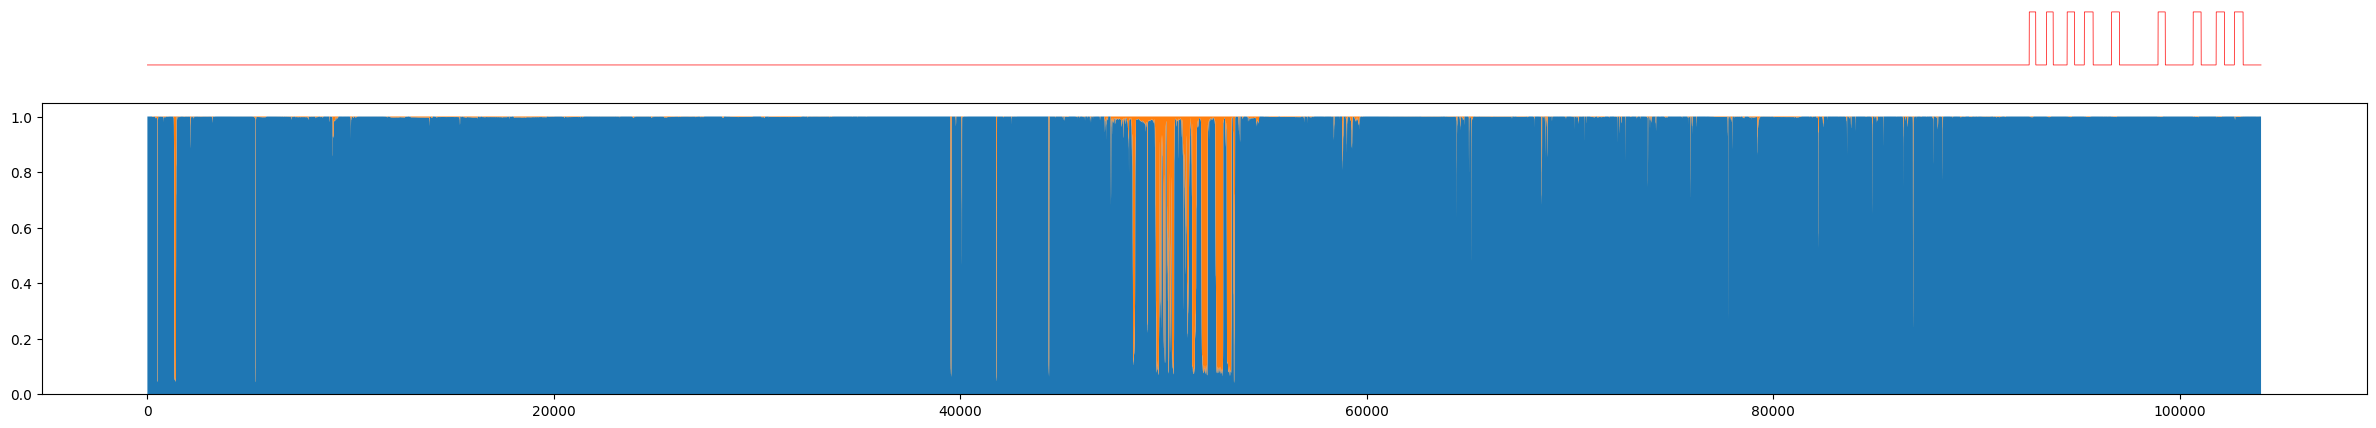

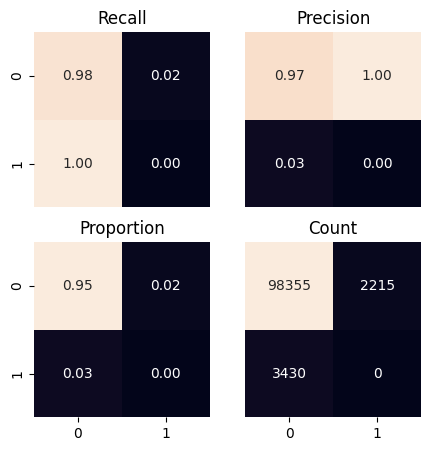

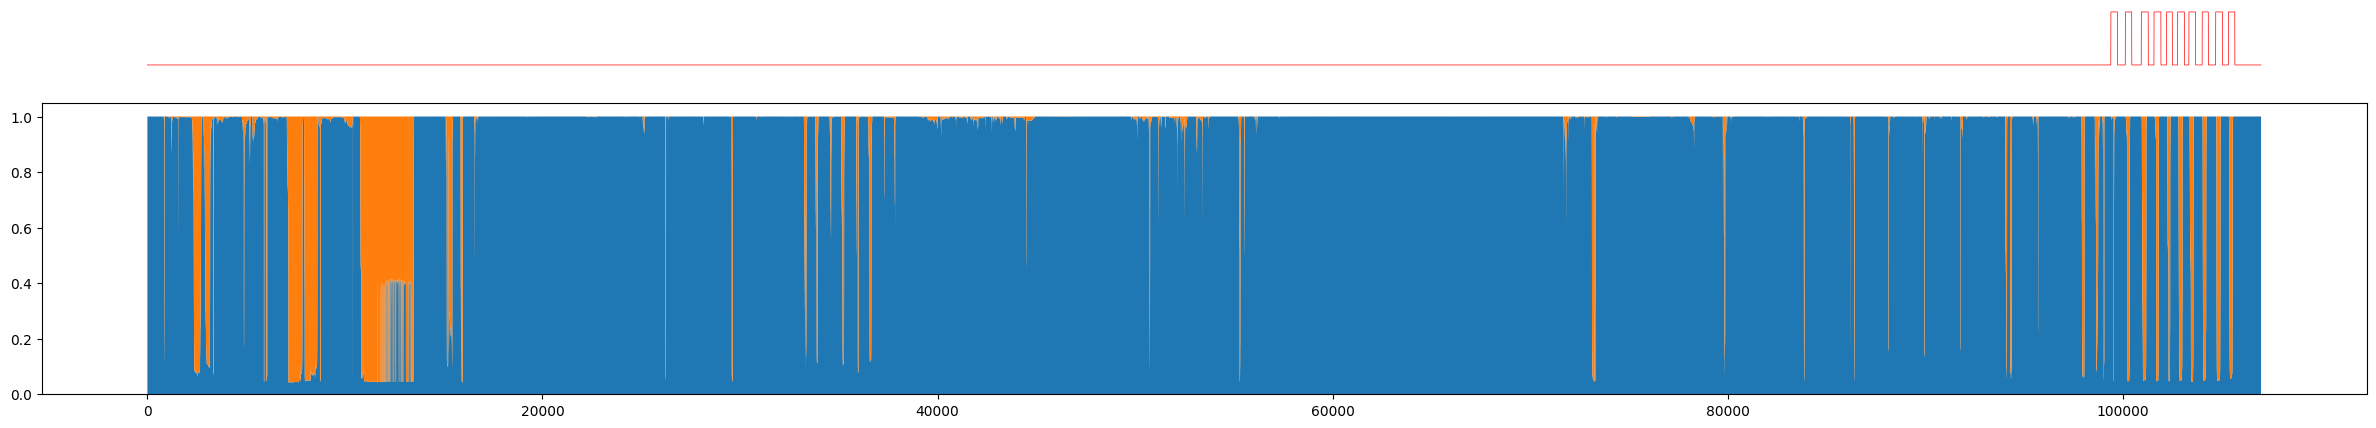

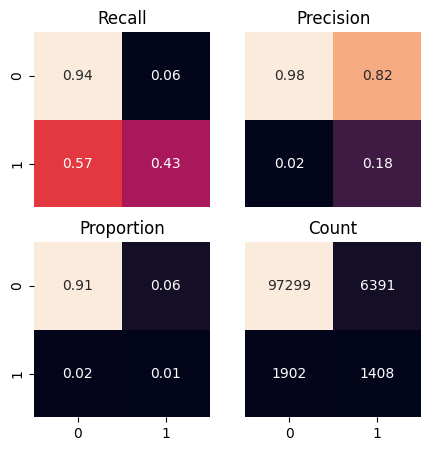

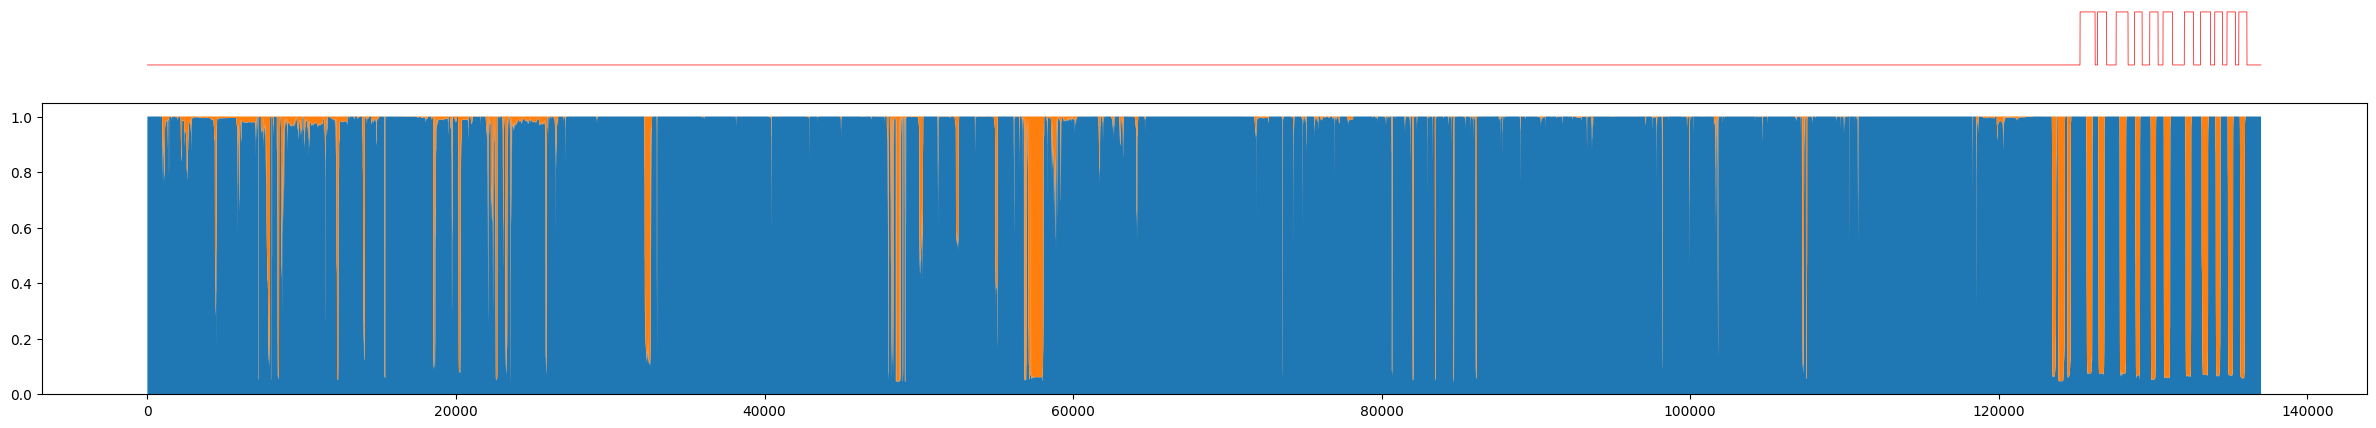

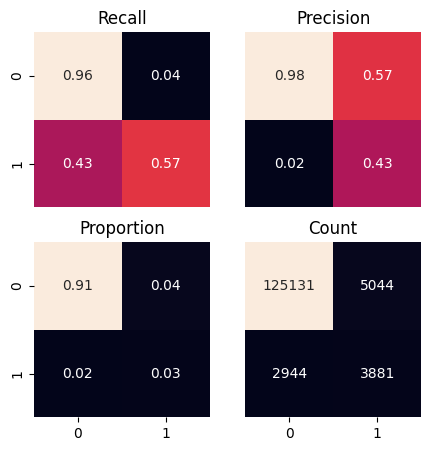

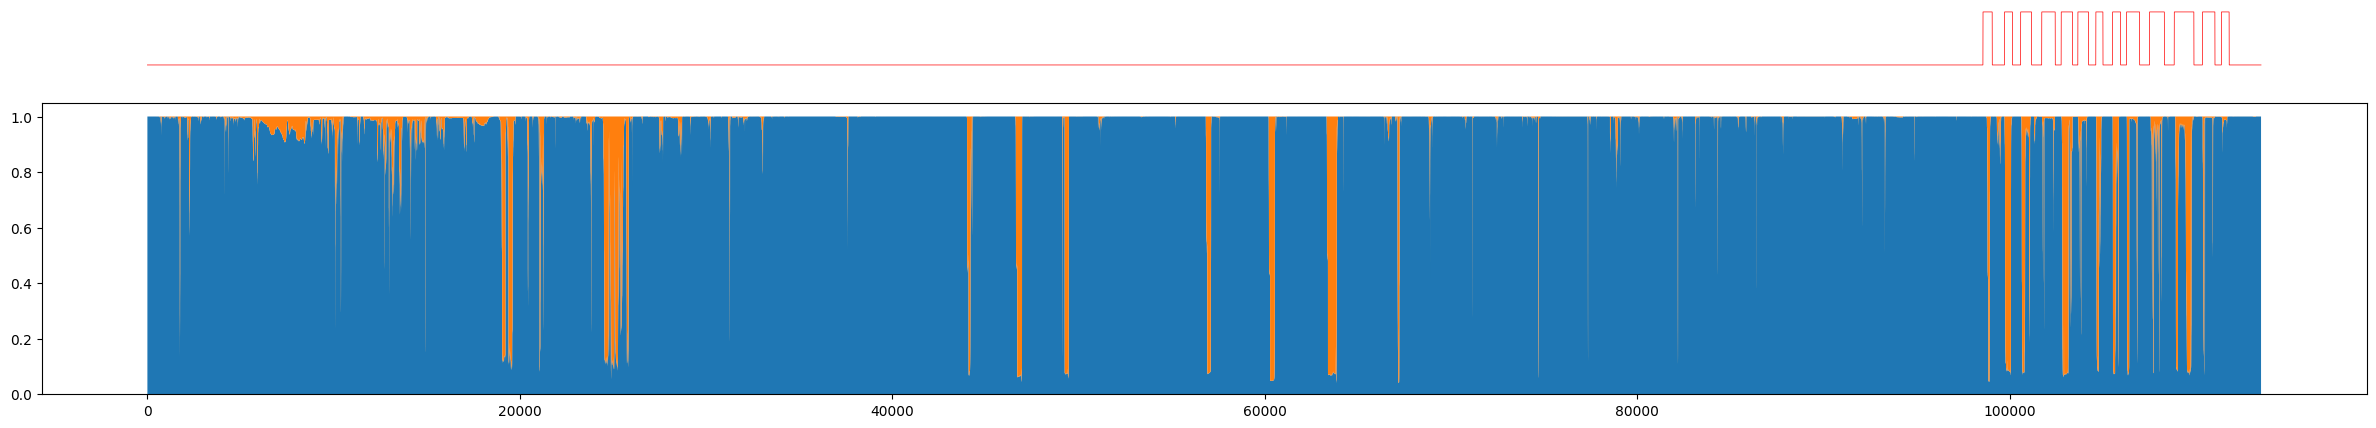

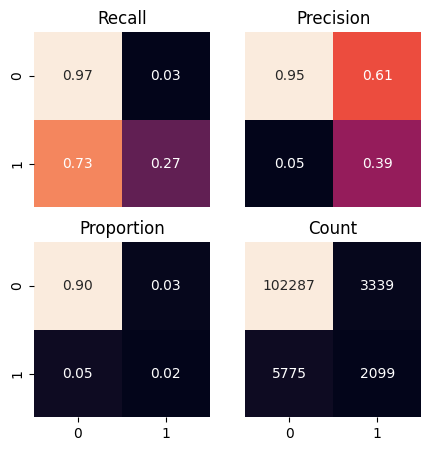

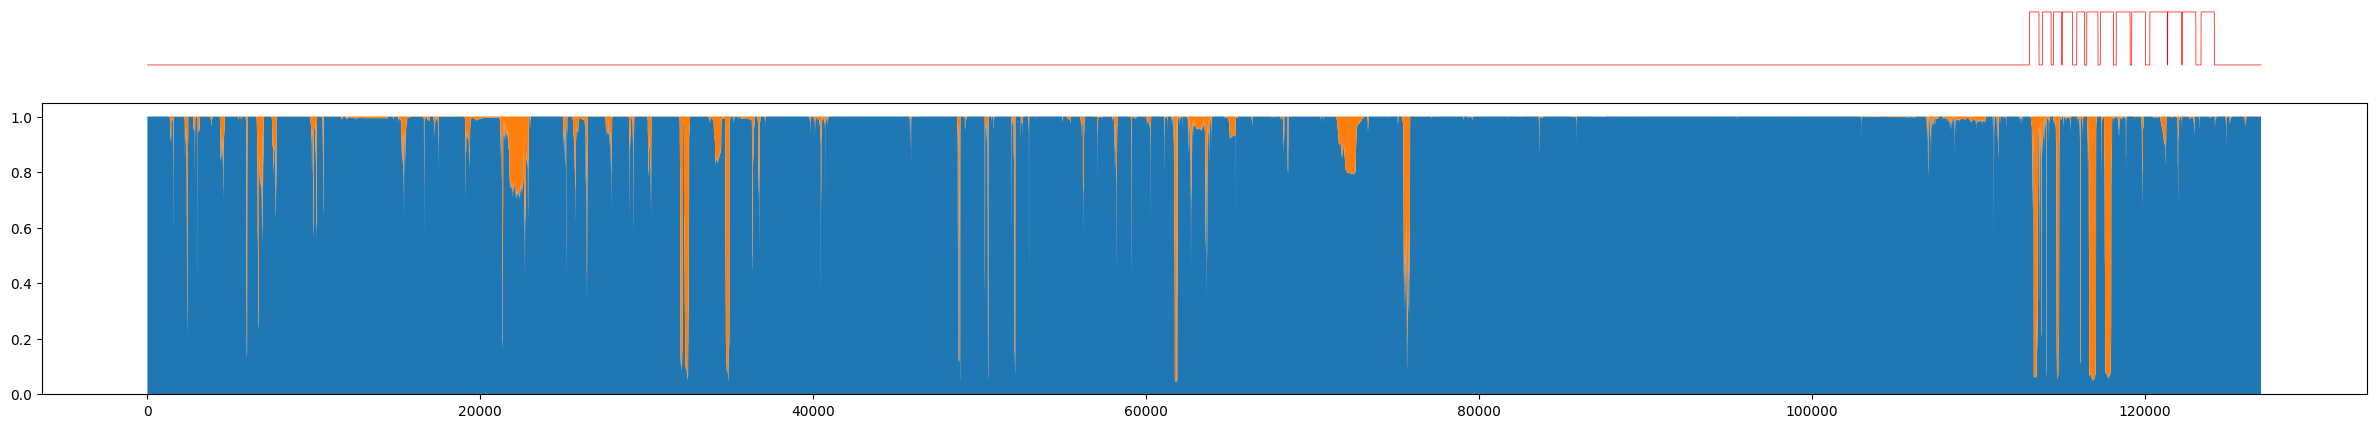

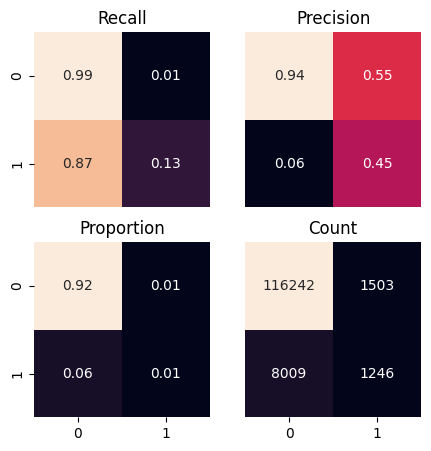

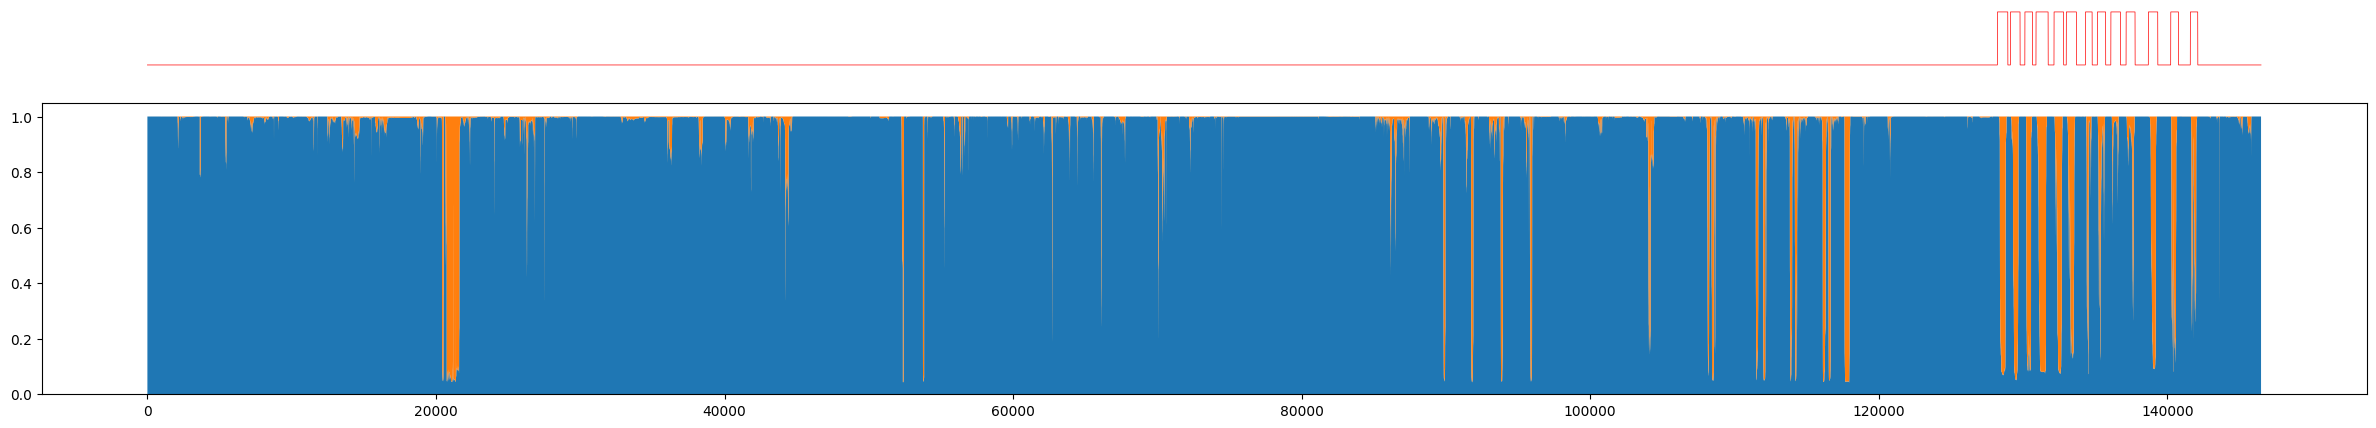

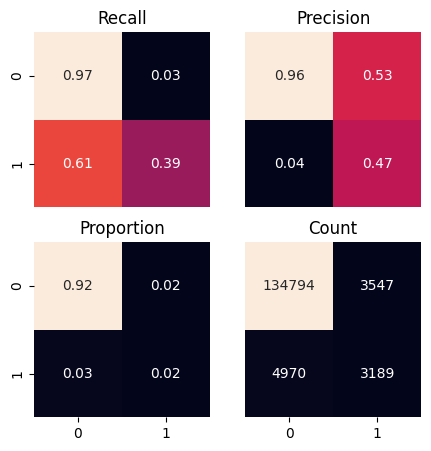

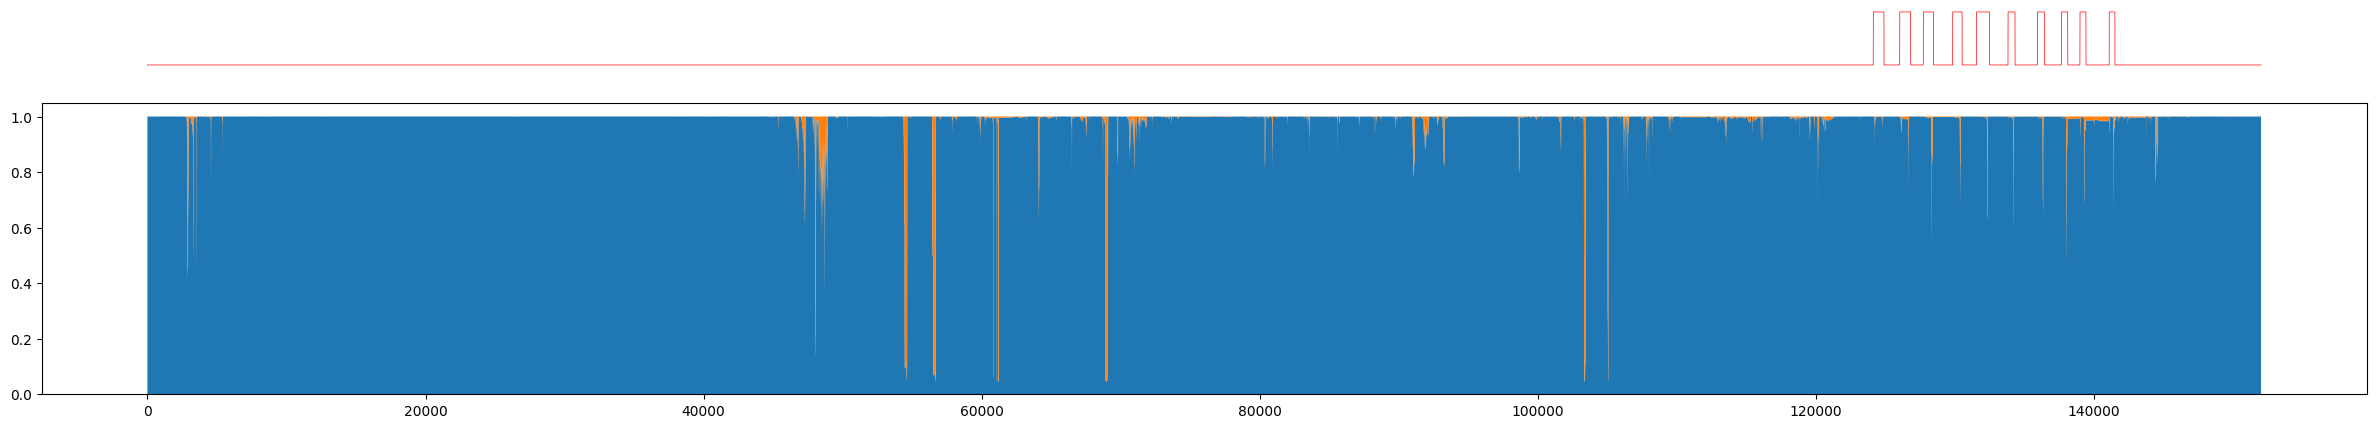

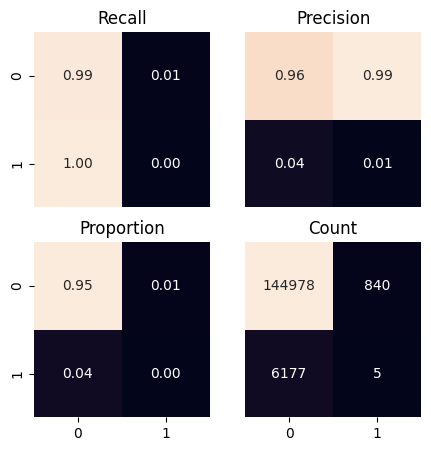

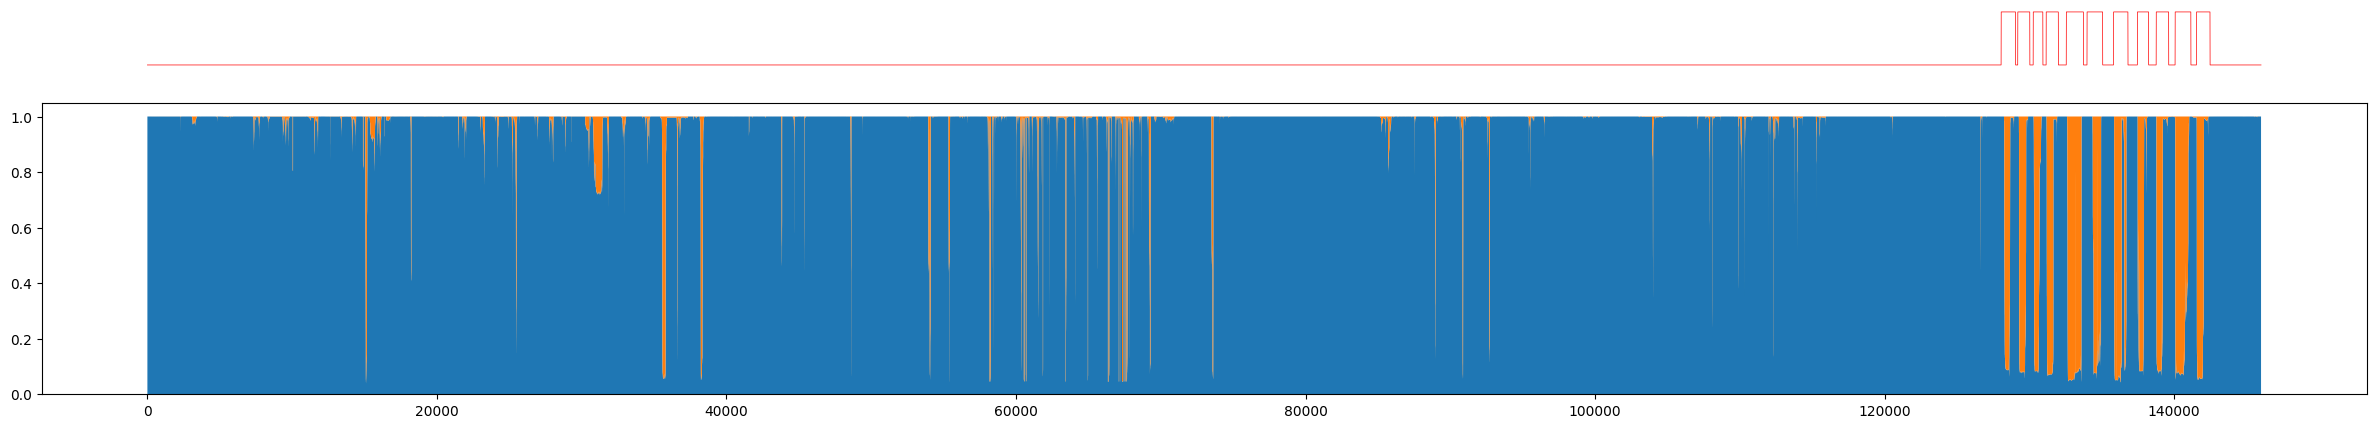

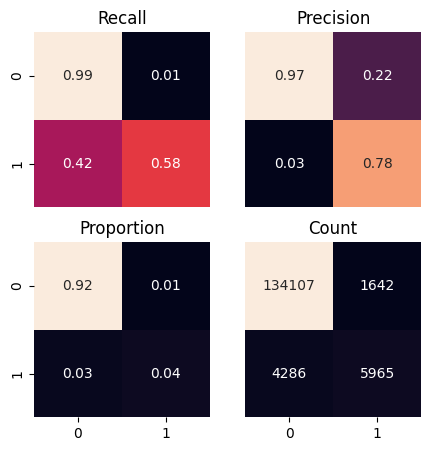

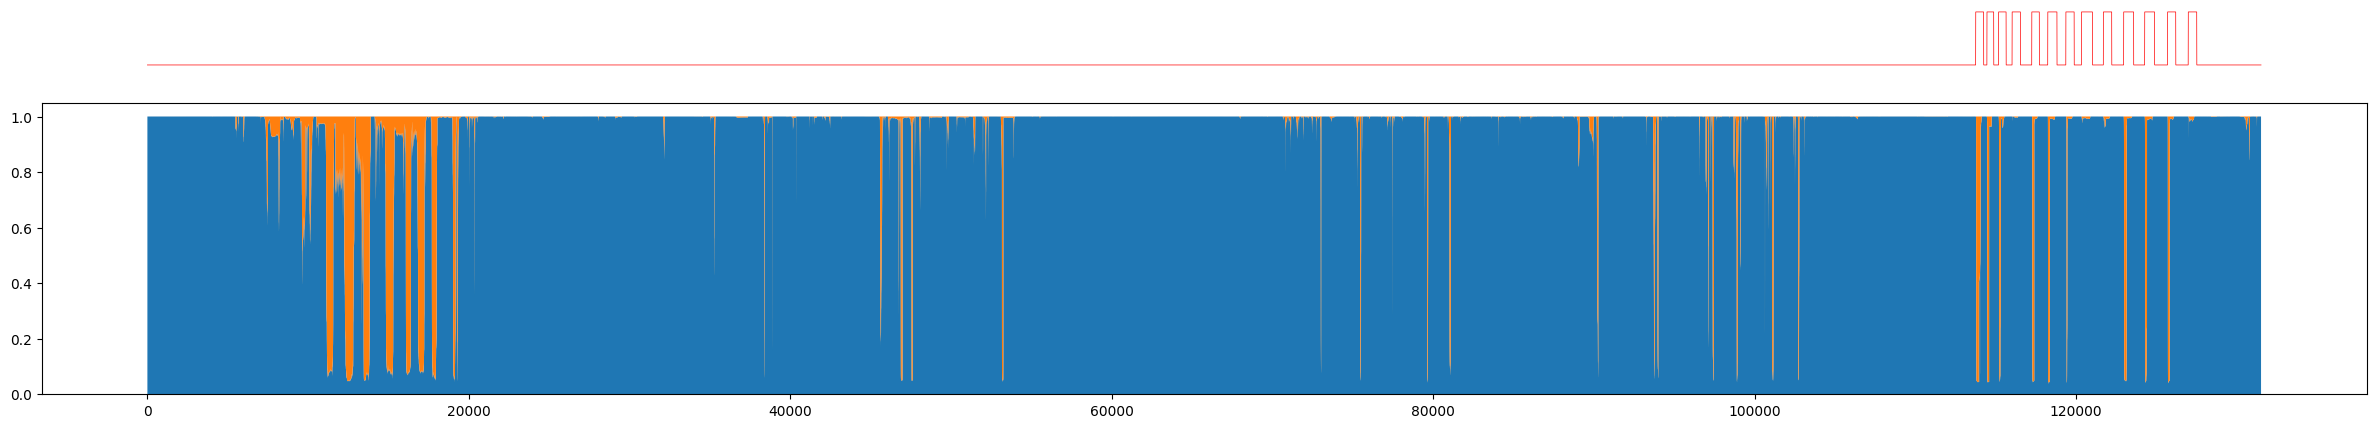

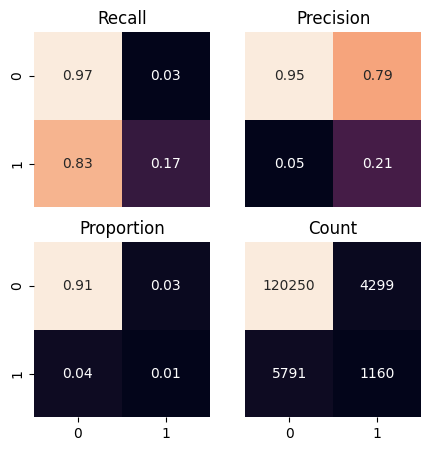

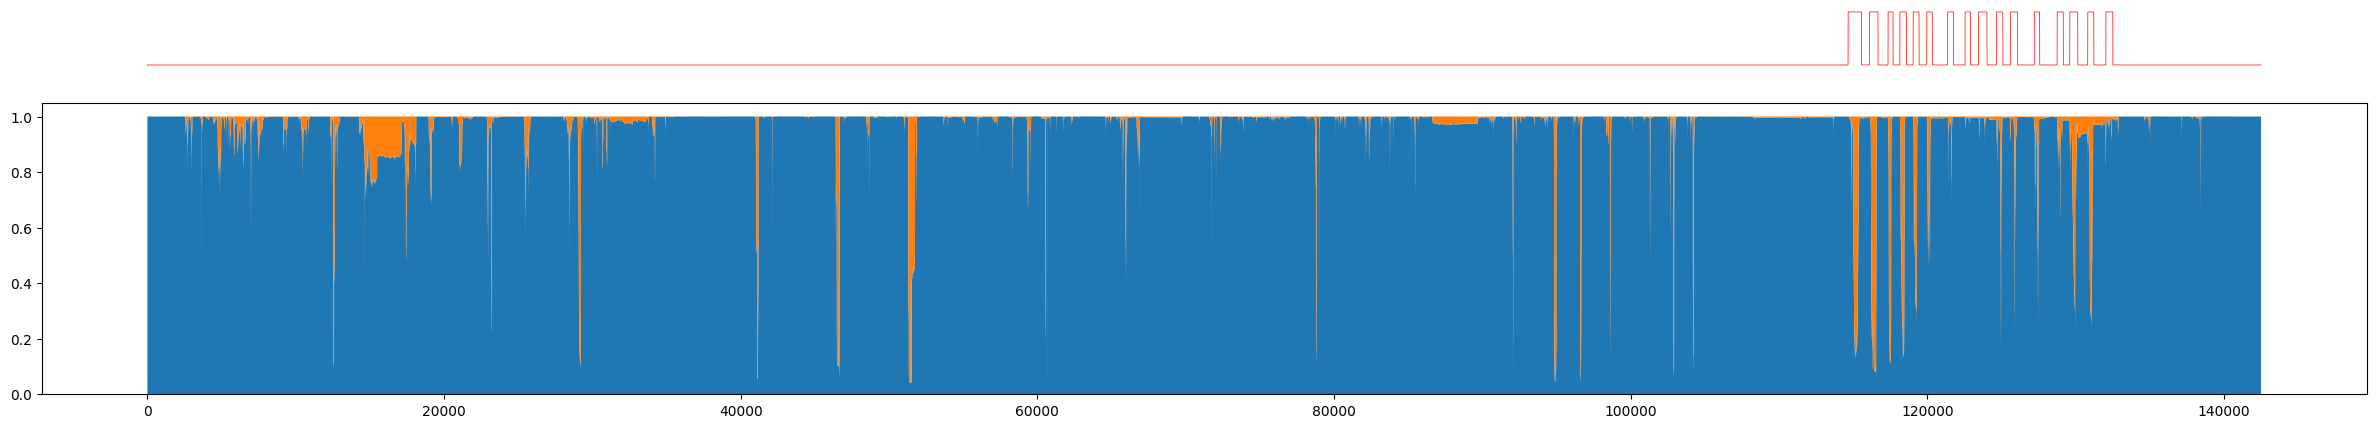

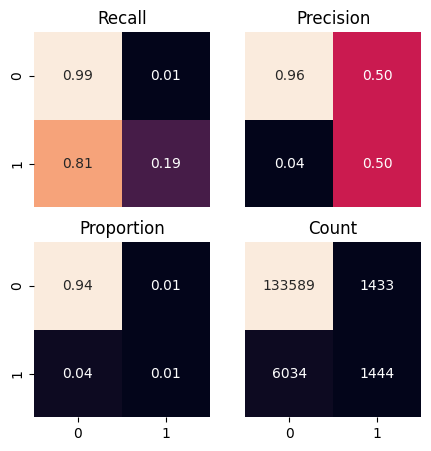

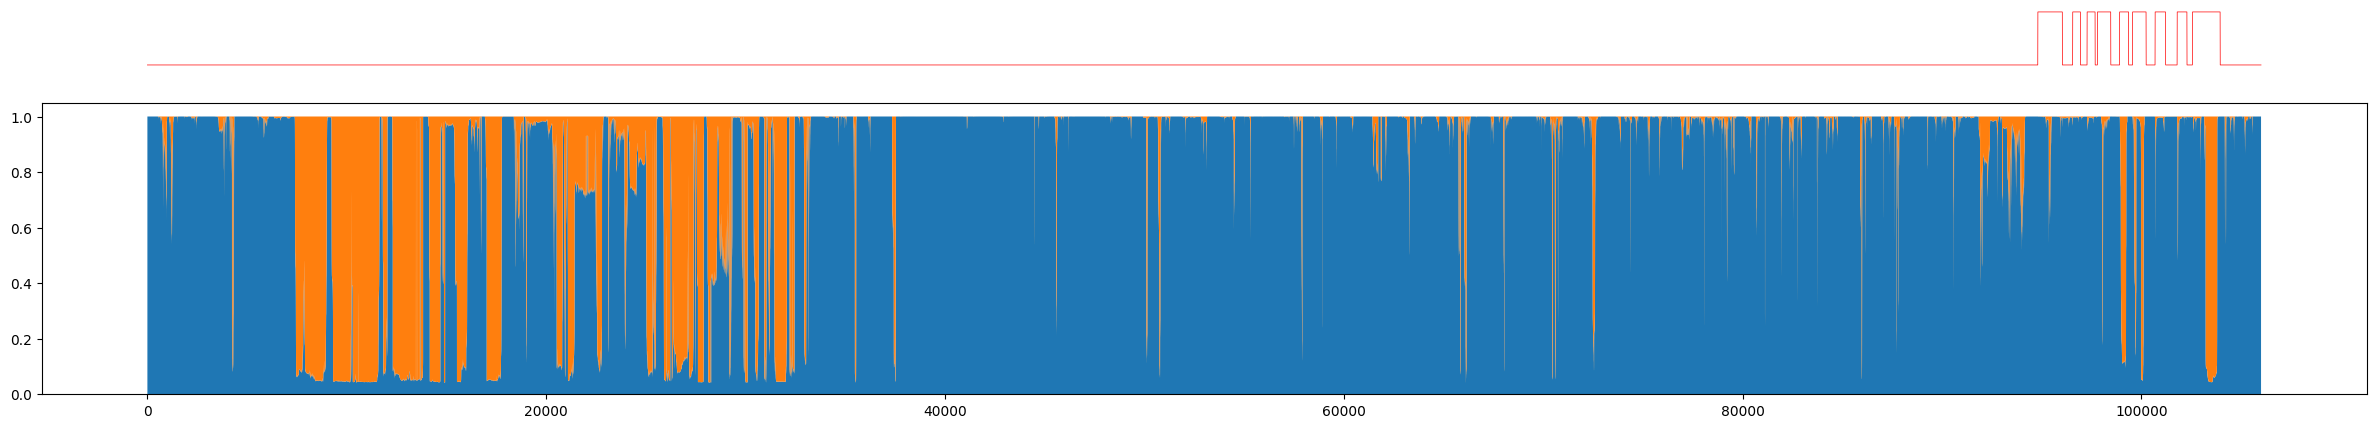

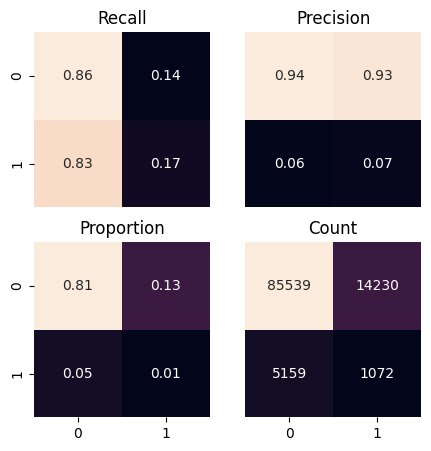

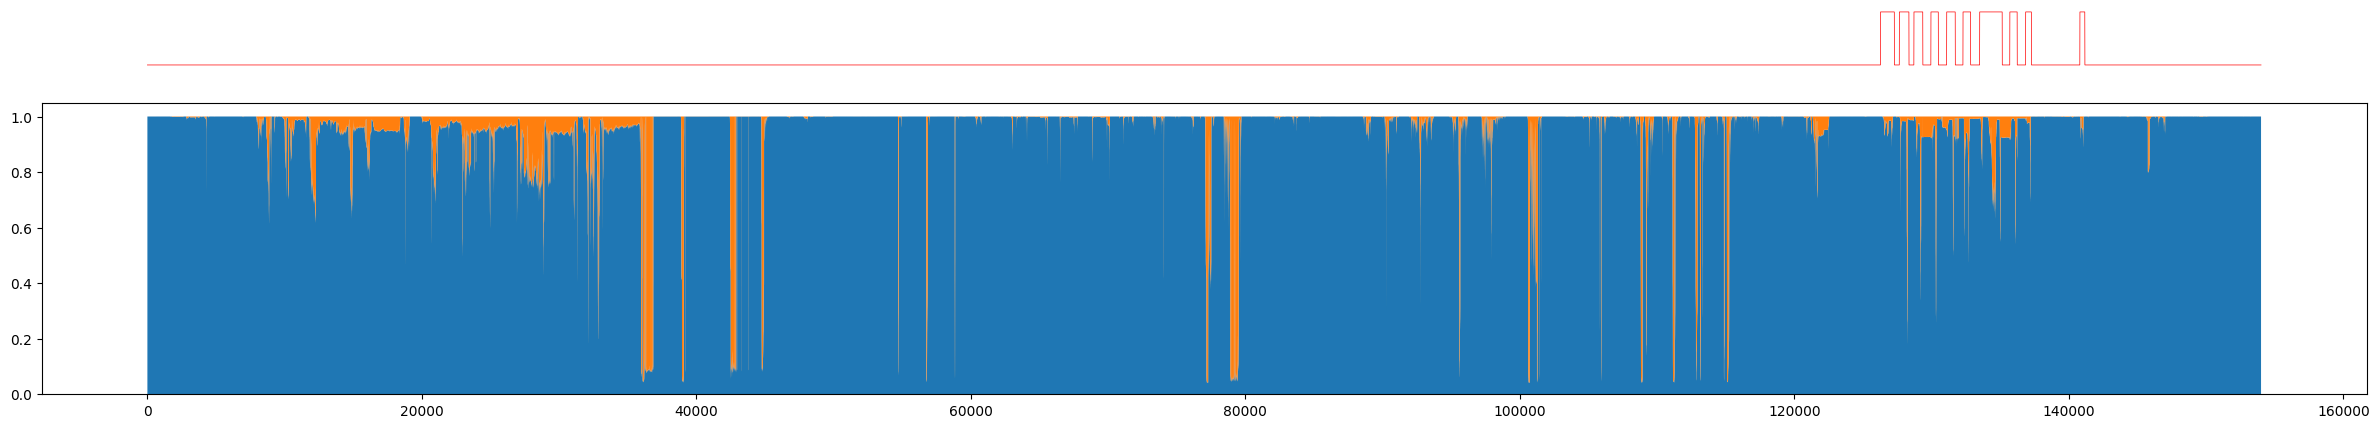

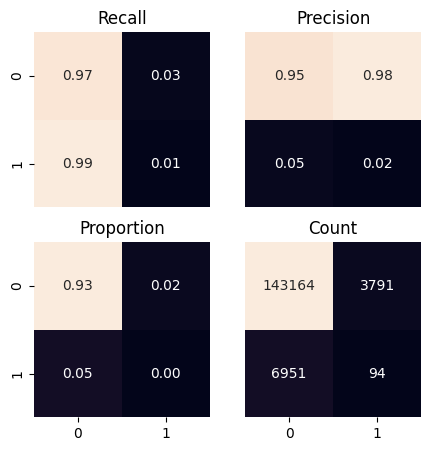

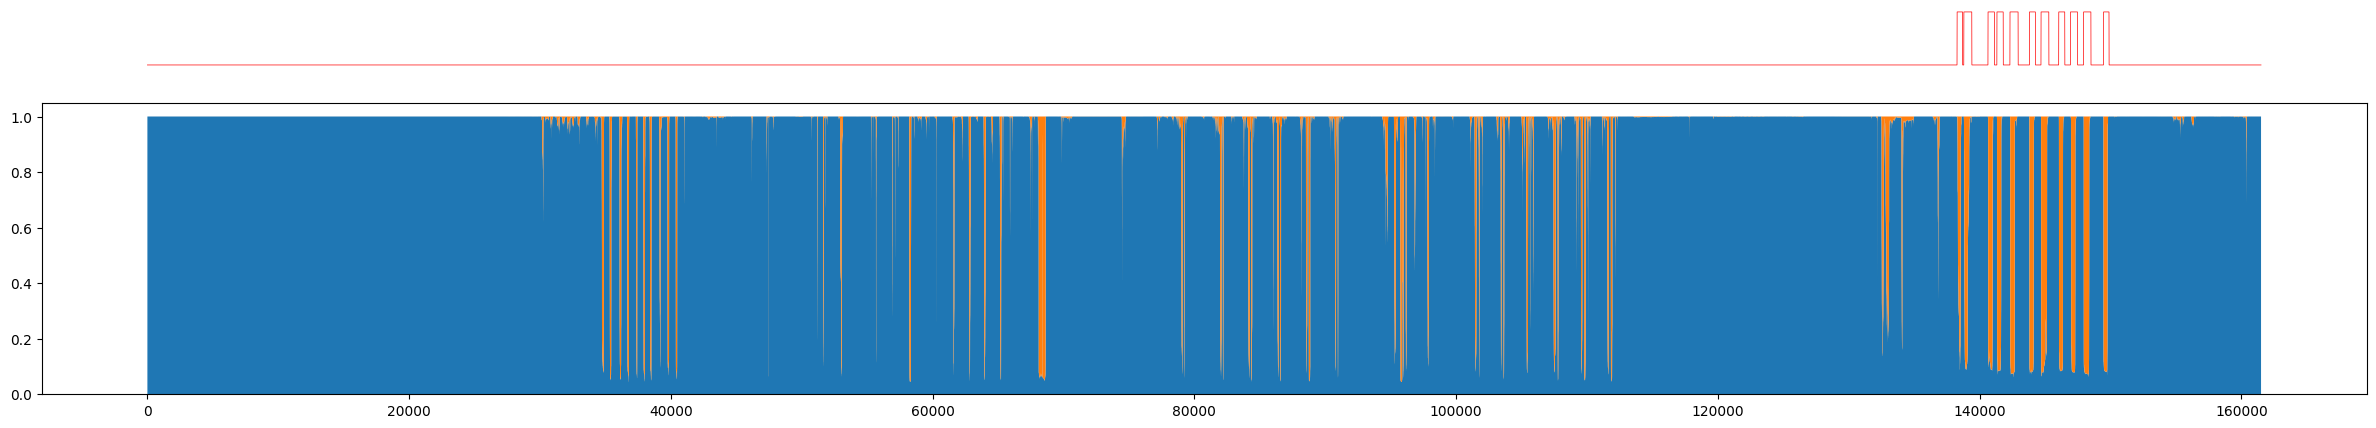

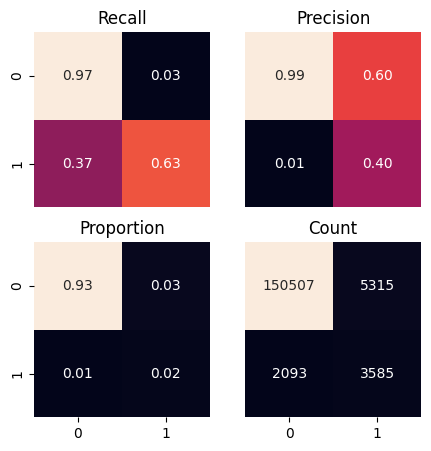

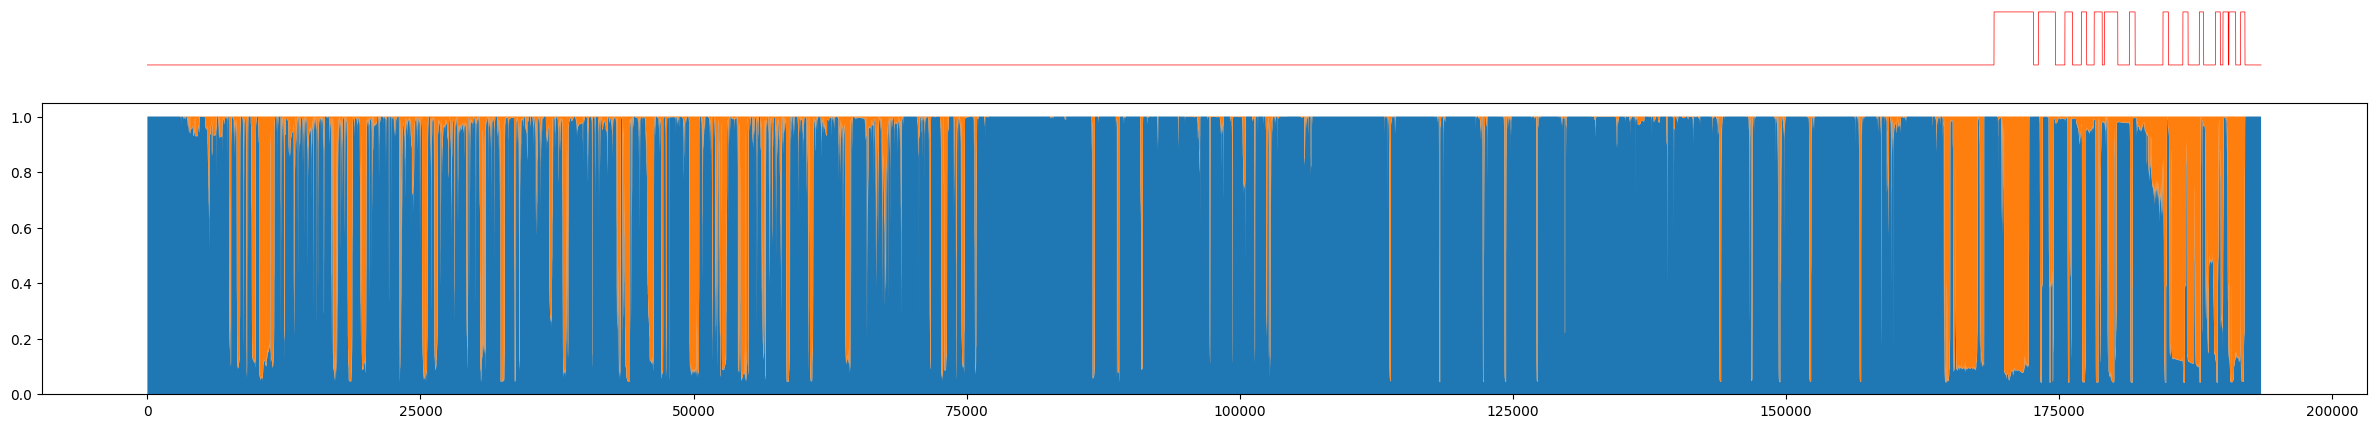

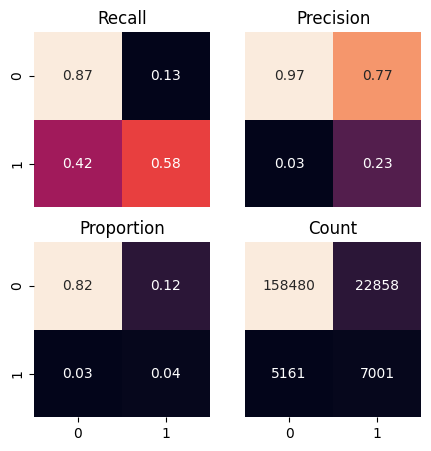

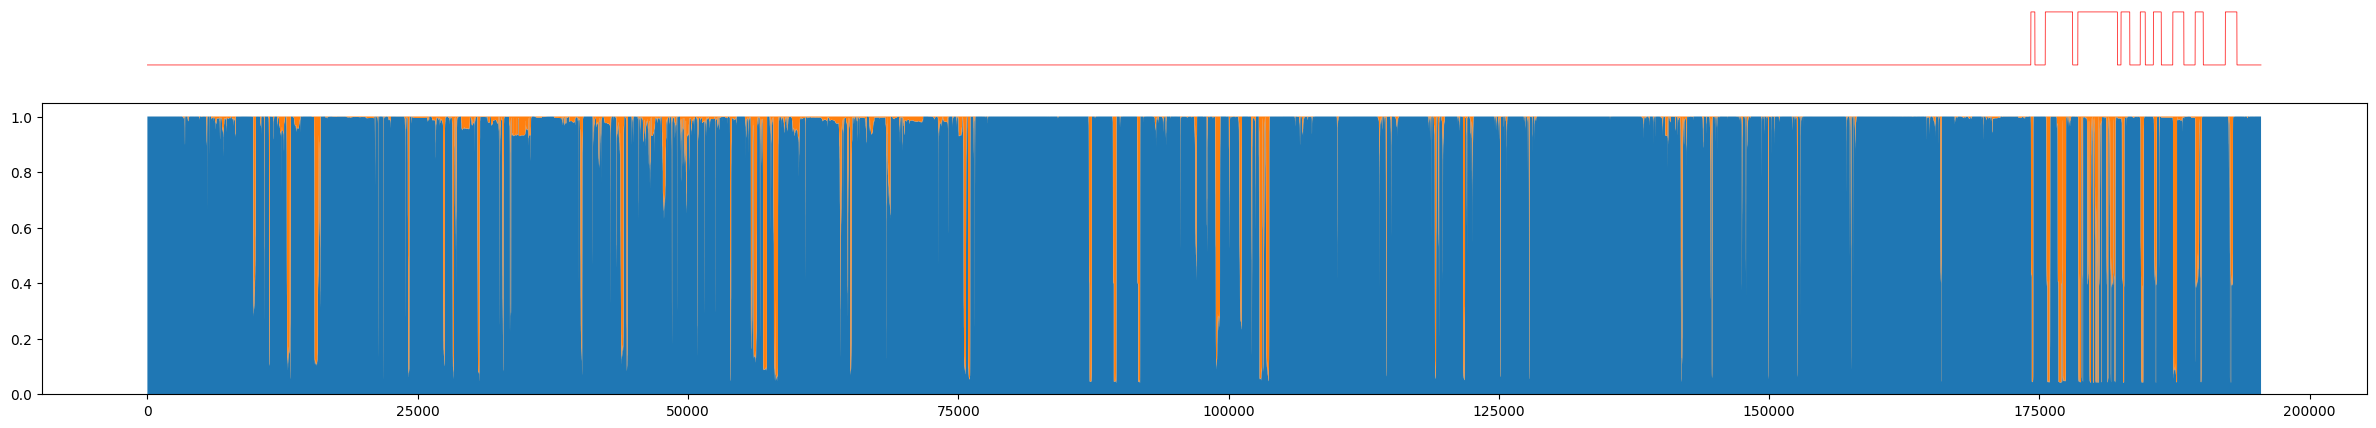

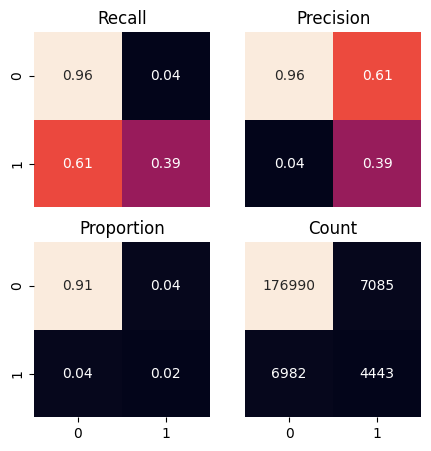

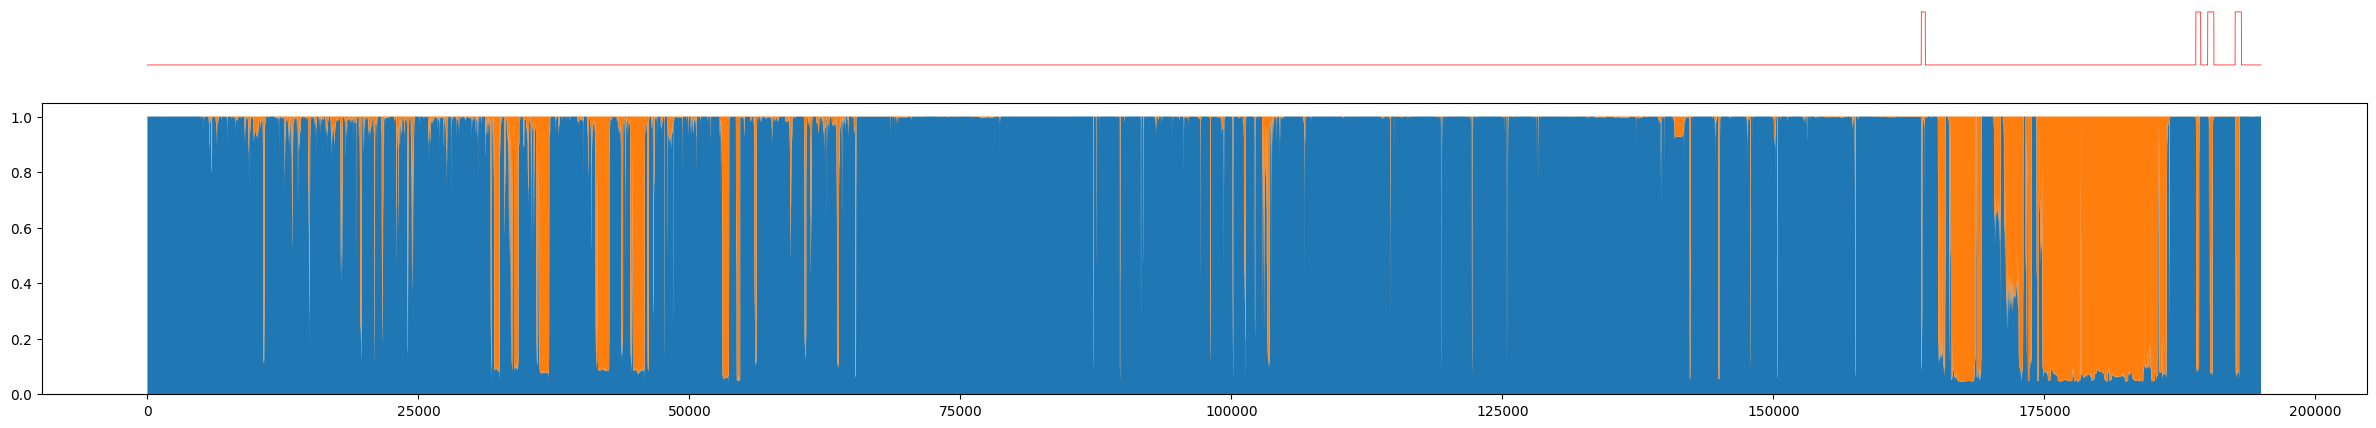

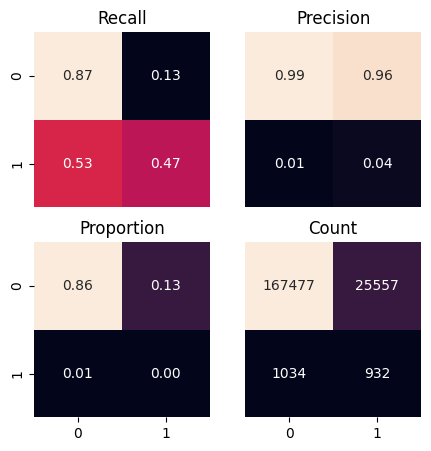

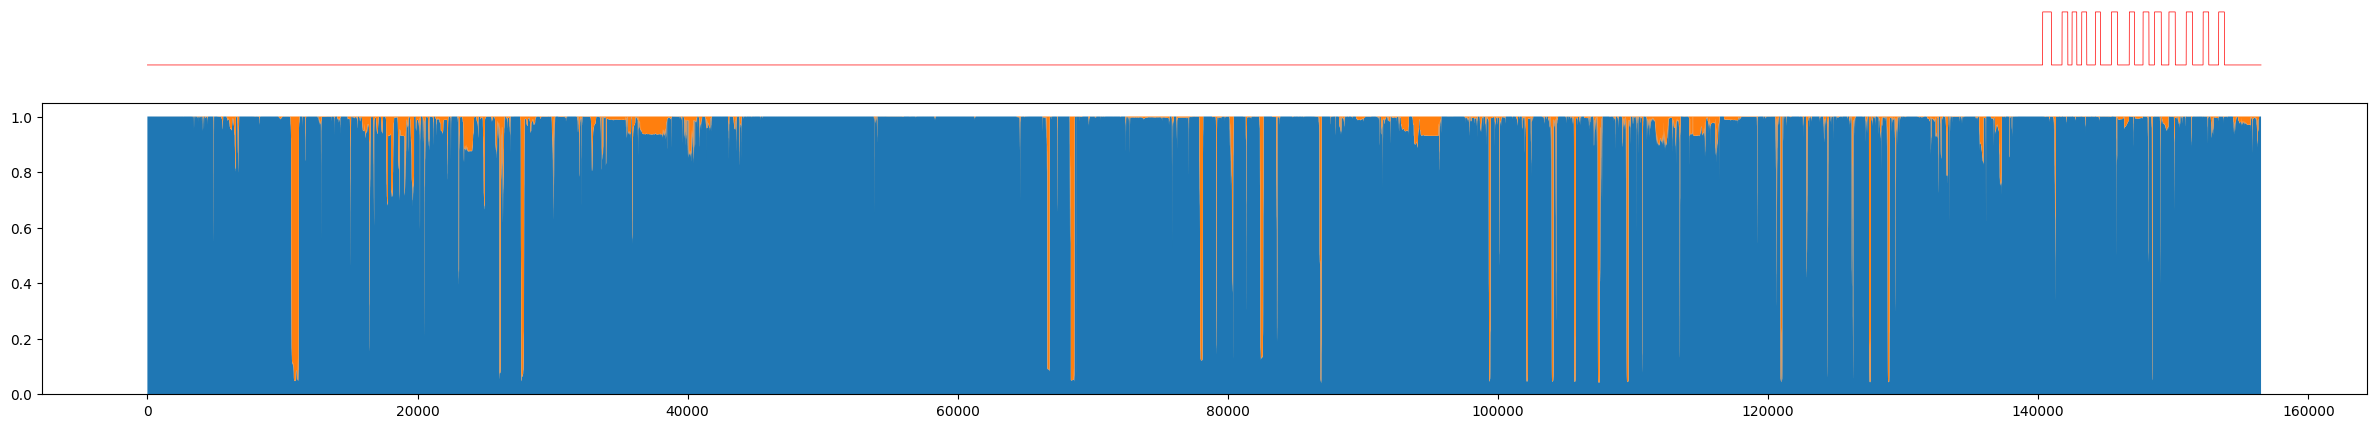

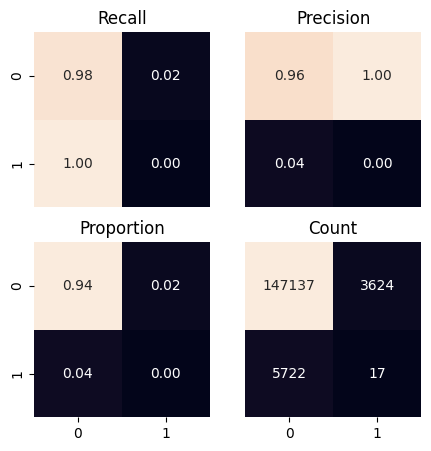

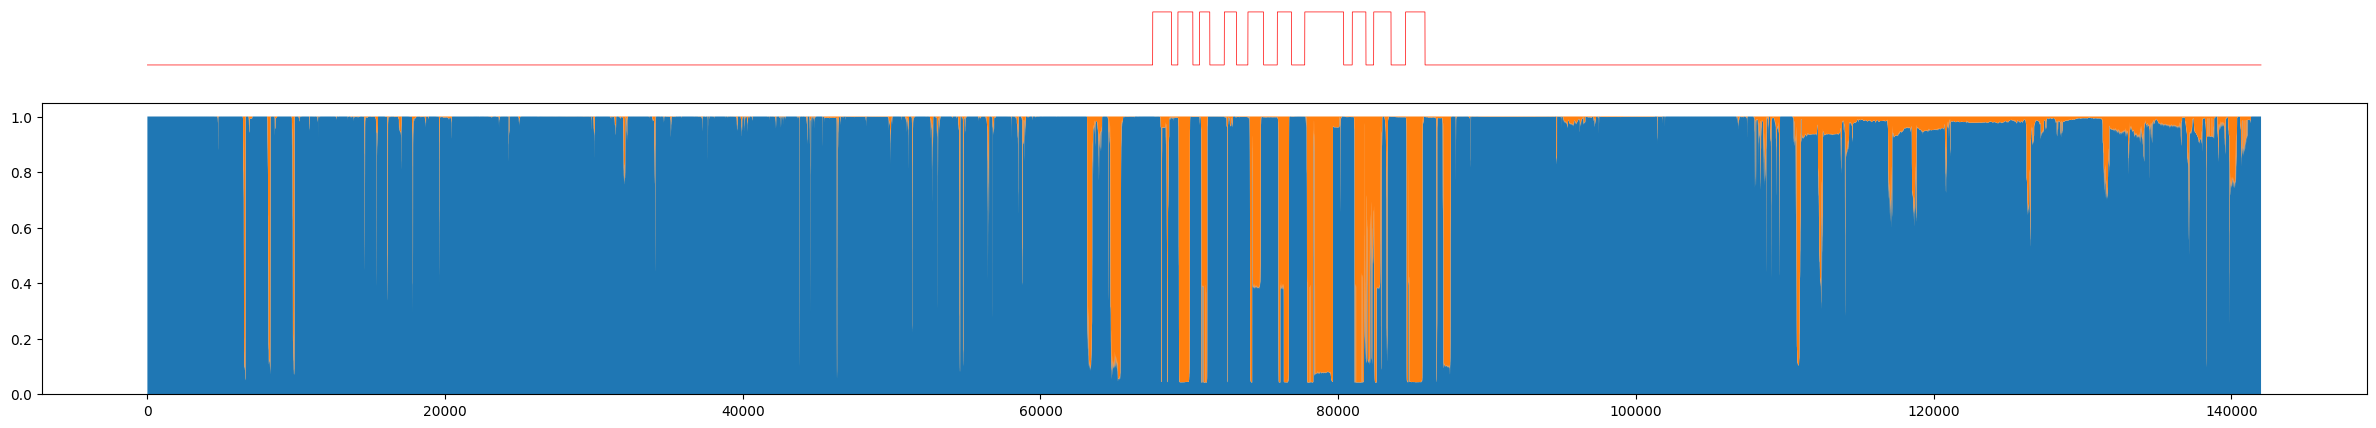

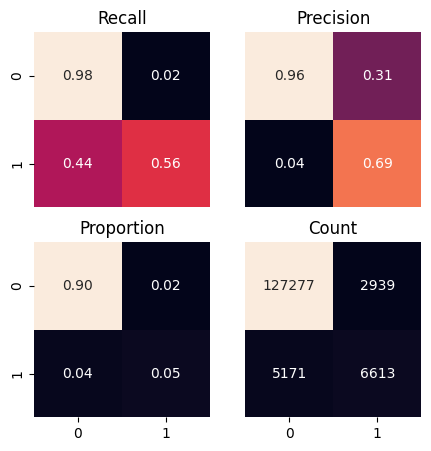

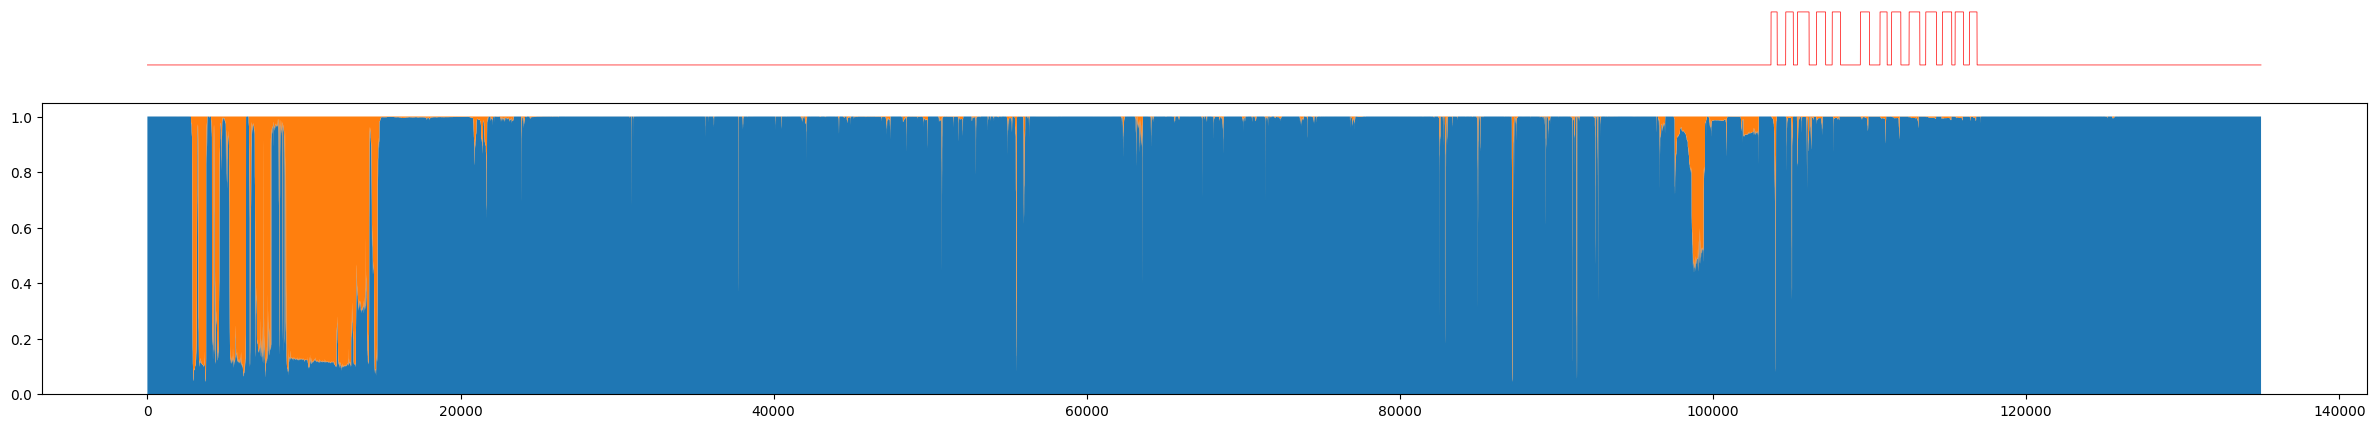

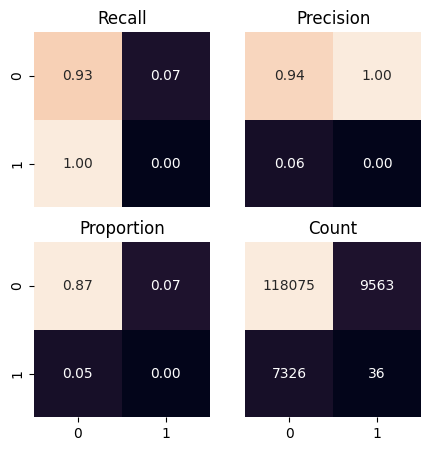

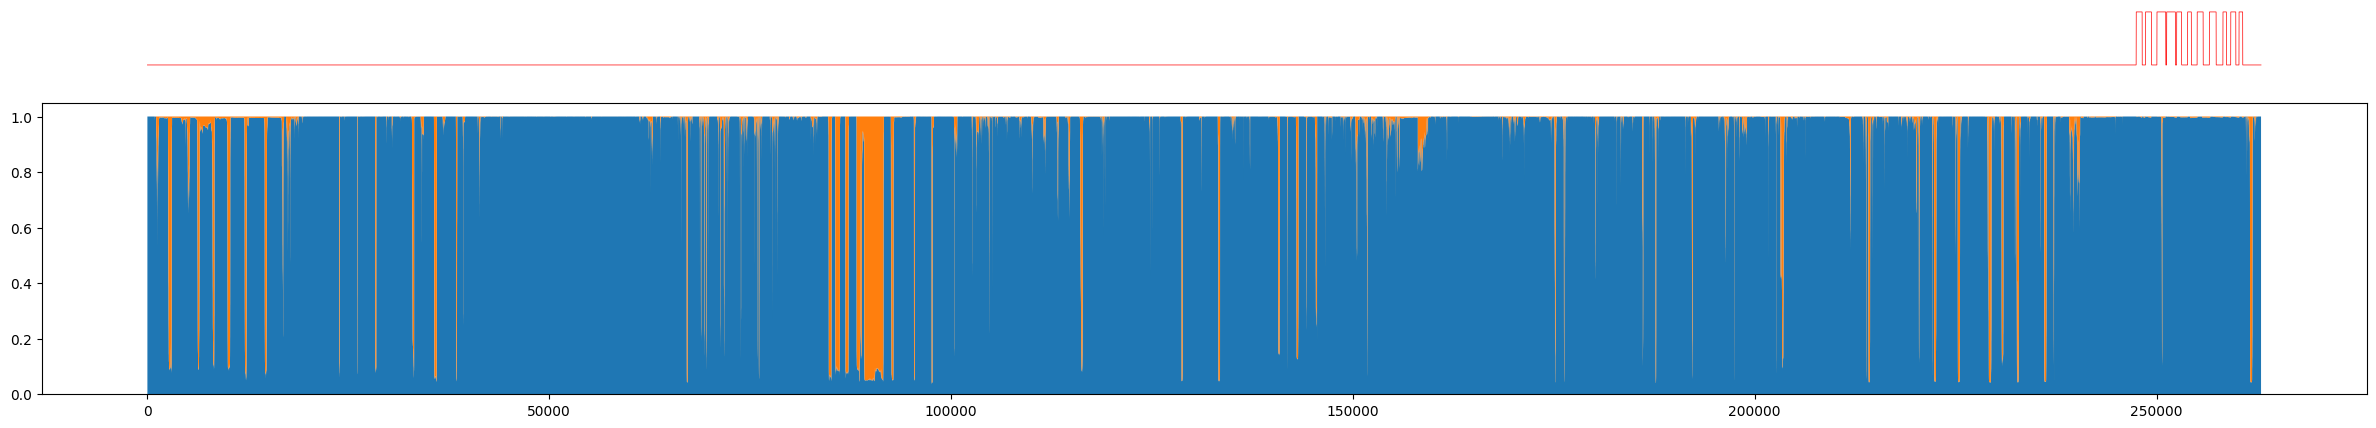

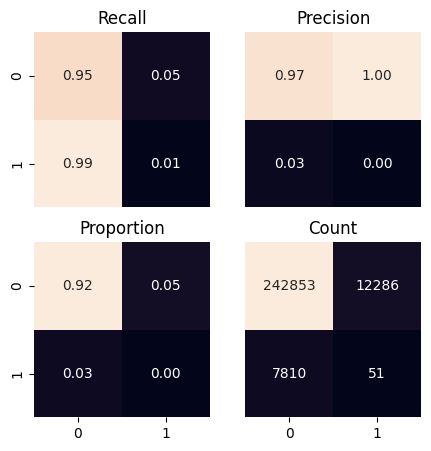

In [44]:
for i in range(1,30):
    skip_idx = [19,24,26,32,34,38,40,45,52,55,70]
    if(i in skip_idx):
        continue
    print(i)
    windowsize = 101
    X,y = load_feature_label_pair(i)
    X = window_epoched_signal(X,101)
    testloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=False)
    loss,metric,y_true,y_pred,y_logits = evaluate(testloader,model,criterion)
    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(30,5),gridspec_kw={'height_ratios': [1,5]})
    axes[0].plot(y_true,'r',linewidth=.5)
    axes[0].axis('off')
    plt.stackplot(torch.arange(len(y_logits)),torch.hstack([torch.ones_like(y_logits) - y_logits,y_logits]).T)
    plt.savefig(f'{i}.svg',bbox_inches='tight')
    cm_grid(y_true,y_pred,save_path=f'{i}.cm.svg')
    print(loss)
    print(metric)